In [301]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import IPython
import IPython.display
import pandas as pd
import numpy as np
import math
import scipy
import tempfile
import statsmodels.formula.api as smf
import statsmodels.api as sm
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler

# Make numpcy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import layers
from tensorflow.keras.utils import to_categorical #type: ignore
import matplotlib.pyplot as plt
import matplotlib as mat
#import colordict as cd
import seaborn as sns

from flowability_data_upload.Research import main
from flowability_data_upload.Research.main import trymodel, makemodel, modeltest

from statsmodels.graphics.regressionplots import abline_plot

from flowability_data_upload.Research.main import trymodel, makemodel, modeltest, Data

import matplotlib.pyplot as plt
from matplotlib import cm  
from mpl_toolkits.mplot3d import Axes3D


In [302]:
%matplotlib inline  
%matplotlib notebook

In [303]:
%%capture

def load_data():
    x = Data()
    x.importnewpowders()
    df_data = pd.DataFrame(x.data)
    df_flow = pd.DataFrame(x.flow)
    df_noflow = pd.DataFrame(x.noflow)

    return df_data, df_flow, df_noflow

df_data, df_flow, df_noflow = load_data()

In [304]:
pd.set_option('display.max_columns', None)
df_data.describe()

,Da,Dp,FWidth,FLength,ELength,EWidth,Volume,Area,Perimeter,CHull Area,CHull Perimeter,Sphericity,Compactness,Roundness,Ellipse Ratio,Circularity,Solidity,Concavity,Convexity,Extent,Transparency,Curvature,Surface Area,L/W Ratio,W/L Aspect Ratio,CHull Surface Area,Ellipticity,Flow,Flow Class
count,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,2.714330e+05,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000
mean,17.437426,19.584505,16.006094,20.989617,20.064784,15.574809,1.194712e+04,394.803286,61.526533,417.306852,58.768829,0.899650,0.831908,0.699995,0.794656,0.813635,0.944927,0.055073,0.969058,0.711475,0.369702,0.030291,1579.213144,1.348371,0.769345,1669.227407,1.321048,17.321739,0.557965
std,14.093120,16.539802,12.996290,17.264877,17.008509,12.737594,8.588047e+04,897.617276,51.961316,966.819265,47.467115,0.065308,0.089029,0.141272,0.148346,0.112077,0.046066,0.046066,0.034497,0.052250,0.059026,0.205644,3590.469105,0.303105,0.129415,3867.277062,0.359398,19.867035,0.496630
min,2.579000,3.620000,3.000000,3.840000,2.950000,2.067000,8.985000e+00,5.225000,11.373000,7.423000,11.046000,0.435000,0.291000,0.084000,0.098000,0.189000,0.700000,0.000000,0.548000,0.380000,0.000000,0.000000,20.900000,1.015000,0.124000,29.692000,1.000000,0.000000,0.000000
25%,8.120000,8.978000,7.462000,9.802000,9.166000,7.170000,2.803440e+02,51.787000,28.206000,54.896000,27.675000,0.867000,0.780000,0.608000,0.709000,0.752000,0.928000,0.024000,0.959000,0.686000,0.333000,0.000000,207.147000,1.150000,0.693000,219.583000,1.097000,0.000000,0.000000
50%,12.486000,13.765000,11.378000,14.978000,14.183000,11.128000,1.019258e+03,122.447000,43.244000,129.397000,42.106000,0.917000,0.850000,0.722000,0.832000,0.841000,0.958000,0.042000,0.982000,0.722000,0.383000,0.000000,489.787000,1.255000,0.797000,517.590000,1.201000,14.430000,1.000000
75%,22.466000,24.995000,20.670000,26.623000,25.589000,20.080000,5.936972e+03,396.400000,78.524000,419.254000,75.287000,0.949000,0.900000,0.810000,0.911000,0.900000,0.976000,0.072000,0.992000,0.748000,0.416000,0.000000,1585.602000,1.442000,0.869000,1677.015000,1.410000,34.310000,1.000000
max,395.289000,841.622000,375.143000,514.872000,473.644000,371.279000,3.234010e+07,122720.860000,2644.034000,145923.674000,1448.384000,0.993000,0.987000,0.974000,1.000000,0.986000,1.000000,0.300000,1.000000,0.894000,0.674000,6.250000,490883.440000,8.085000,0.985000,583694.696000,10.246000,64.303333,1.000000


# Training Classifiers

## Flow Class Prediction

In [305]:
#Flow Class Imbalance

neg, pos = np.bincount(df_data['Flow Class']) #type: ignore
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 271433
    Positive: 151450 (55.80% of total)



### Data Cleaning

In [306]:
cleaned_df = df_data.copy().reset_index(drop = True)
powder = cleaned_df.pop('Flow')
powder = cleaned_df.pop('Powder')

## Model Class

In [307]:
class Model:
    def __init__(self, name, num_classes = 2):
        self.name = name
        self.num_classes = num_classes

        self.EPOCHS = 100
        self.BATCH_SIZE = 2048
        

In [308]:
regular_model = Model(name = "Regular")
boxcox_model = Model(name="Boxcox Transform")

### Train Test Split

In [309]:
def split_transform_data(self, cleaned_df, target = 'Flow Class', use_boxcox = False):
    # Use a utility from sklearn to split and shuffle your dataset.
    train_df, self.test_df = train_test_split(cleaned_df, test_size=0.2)

    if use_boxcox:
        for col in train_df.columns[:-1]: #all except last (assuming target)
            fit_values, fit_lambda = scipy.stats.boxcox(train_df[col].values + 0.0001)
            train_df[col] = fit_values
            self.test_df[col] = scipy.stats.boxcox(self.test_df[col].values + 0.0001, fit_lambda)

    self.train_df, self.val_df = train_test_split(train_df, test_size=0.2)

    # Form np arrays of labels and features.
    self.train_labels = np.array(self.train_df.pop(target))
    self.bool_train_labels = self.train_labels != 0
    self.val_labels = np.array(self.val_df.pop(target))
    self.test_labels = np.array(self.test_df.pop(target))

    self.train_features = np.array(self.train_df)
    self.val_features = np.array(self.val_df)
    self.test_features = np.array(self.test_df)
      

Model.split_transform_data = split_transform_data

In [310]:
regular_model.split_transform_data(cleaned_df, use_boxcox=False)
boxcox_model.split_transform_data(cleaned_df, use_boxcox=True)

### Apply Standard Scaling

In [311]:
def apply_StandardScaler(self):
    scaler = MinMaxScaler()
    self.train_features = scaler.fit_transform(self.train_features)

    self.val_features = scaler.transform(self.val_features)
    self.test_features = scaler.transform(self.test_features)

    self.train_features = np.clip(self.train_features, -5, 5)
    self.val_features = np.clip(self.val_features, -5, 5)
    self.test_features = np.clip(self.test_features, -5, 5)


    print('Training labels shape:', self.train_labels.shape)
    print('Validation labels shape:', self.val_labels.shape)
    print('Test labels shape:', self.test_labels.shape)

    print('Training features shape:', self.train_features.shape)
    print('Validation features shape:', self.val_features.shape)
    print('Test features shape:', self.test_features.shape)

Model.apply_StandardScaler = apply_StandardScaler

In [312]:
regular_model.apply_StandardScaler()
boxcox_model.apply_StandardScaler()

Training labels shape: (173716,)
Validation labels shape: (43430,)
Test labels shape: (54287,)
Training features shape: (173716, 27)
Validation features shape: (43430, 27)
Test features shape: (54287, 27)
Training labels shape: (173716,)
Validation labels shape: (43430,)
Test labels shape: (54287,)
Training features shape: (173716, 27)
Validation features shape: (43430, 27)
Test features shape: (54287, 27)


### Define Model and Metrics

In [313]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

Model.METRICS = METRICS

def make_model(self, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    self.model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(self.train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

    self.model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=self.METRICS)

    return self.model

Model.make_model = make_model

def evaluate_model(self):
    results = self.model.evaluate(self.train_features, self.train_labels, batch_size = self.BATCH_SIZE, verbose=0)
    print("Loss: {:0.4f}".format(results[0]))

Model.evaluate_model = evaluate_model

def fit_model(self):

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_prc', 
        verbose=1,
        patience=10,
        mode='max',
        restore_best_weights=True)

    self.history = self.model.fit(
        self.train_features,
        self.train_labels,
        batch_size=self.BATCH_SIZE,
        epochs=self.EPOCHS,
        callbacks=[early_stopping],
        validation_data=(self.val_features, self.val_labels))

    return self.history

Model.fit_model = fit_model

def predict(self, input):
    # make predictions on the input data using the model
    scaler = StandardScaler()
    scaled_input = scaler.fit_transform(input)

    predictions = self.model.predict(scaled_input)
    
    return predictions

Model.predict = predict
  
def create_model():

    model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(27,)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid'),
  ])

    model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=METRICS)

    return model

### Visualization

In [314]:
def visualize(self):
    pos_df = pd.DataFrame(self.train_features[self.bool_train_labels], columns=self.train_df.columns)
    neg_df = pd.DataFrame(self.train_features[~self.bool_train_labels], columns=self.train_df.columns)

    f1,f2 = np.random.choice(self.train_df.columns, 2, replace=False)

    sns.jointplot(x=pos_df[f1], y=pos_df[f2],
                kind='hex', xlim=(-5,5), ylim=(-5,5))
    plt.suptitle("Positive distribution")

    sns.jointplot(x=neg_df[f1], y=neg_df[f2],
                kind='hex', xlim=(-5,5), ylim=(-5,5))
    _ = plt.suptitle("Negative distribution")

Model.visualize = visualize

def plot_metrics(self):

    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    metrics = ['loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(self.history.epoch, self.history.history[metric], color=colors[0], label='Train')
        plt.plot(self.history.epoch, self.history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

    plt.legend()

Model.plot_metrics = plot_metrics

def plot_cm(self, p=0.5):
    predictions = self.model.predict(self.test_features)
    cm = confusion_matrix(self.test_labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('No Flow Detected (True Negatives): ', cm[0][0])
    print('Flow Incorrectly Detected (False Positives): ', cm[0][1])
    print('No Flow Incorrectly Detected (False Negatives): ', cm[1][0])
    print('Flow Detected (True Positives): ', cm[1][1])
    print('Total Flow Detected: ', np.sum(cm[1]))

    print((cm[0][0] + cm[1][1]) / (cm[0][0] +  cm[0][1] + cm[1][0] +cm[1][1]))

Model.plot_cm = plot_cm

## Baseline Model

In [315]:
baseline = Model(name = "Baseline Model", num_classes= 2)

baseline.split_transform_data(cleaned_df, use_boxcox=False)

baseline.apply_StandardScaler()

Training labels shape: (173716,)
Validation labels shape: (43430,)
Test labels shape: (54287,)
Training features shape: (173716, 27)
Validation features shape: (43430, 27)
Test features shape: (54287, 27)


In [316]:
first_model = baseline.make_model()
history = baseline.fit_model()
baseline.evaluate_model()

Epoch 1/100
85/85 [==============================] - 3s 15ms/step - loss: 0.8382 - tp: 23617.0000 - fp: 17617.0000 - tn: 59198.0000 - fn: 73284.0000 - accuracy: 0.4767 - precision: 0.5728 - recall: 0.2437 - auc: 0.5085 - prc: 0.5724 - val_loss: 0.6725 - val_tp: 23035.0000 - val_fp: 16769.0000 - val_tn: 2380.0000 - val_fn: 1246.0000 - val_accuracy: 0.5852 - val_precision: 0.5787 - val_recall: 0.9487 - val_auc: 0.6762 - val_prc: 0.7445
Epoch 2/100
85/85 [==============================] - 0s 5ms/step - loss: 0.7070 - tp: 54392.0000 - fp: 37981.0000 - tn: 38834.0000 - fn: 42509.0000 - accuracy: 0.5367 - precision: 0.5888 - recall: 0.5613 - auc: 0.5506 - prc: 0.6142 - val_loss: 0.6564 - val_tp: 17648.0000 - val_fp: 8191.0000 - val_tn: 10958.0000 - val_fn: 6633.0000 - val_accuracy: 0.6587 - val_precision: 0.6830 - val_recall: 0.7268 - val_auc: 0.7269 - val_prc: 0.7816
Epoch 3/100
85/85 [==============================] - 0s 4ms/step - loss: 0.6882 - tp: 55851.0000 - fp: 35437.0000 - tn: 41378

Epoch 20/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5995 - tp: 63301.0000 - fp: 20299.0000 - tn: 56516.0000 - fn: 33600.0000 - accuracy: 0.6897 - precision: 0.7572 - recall: 0.6533 - auc: 0.7467 - prc: 0.7810 - val_loss: 0.5750 - val_tp: 16930.0000 - val_fp: 4703.0000 - val_tn: 14446.0000 - val_fn: 7351.0000 - val_accuracy: 0.7224 - val_precision: 0.7826 - val_recall: 0.6973 - val_auc: 0.7708 - val_prc: 0.8036
Epoch 21/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5983 - tp: 63812.0000 - fp: 20256.0000 - tn: 56559.0000 - fn: 33089.0000 - accuracy: 0.6929 - precision: 0.7591 - recall: 0.6585 - auc: 0.7488 - prc: 0.7824 - val_loss: 0.5744 - val_tp: 17394.0000 - val_fp: 5203.0000 - val_tn: 13946.0000 - val_fn: 6887.0000 - val_accuracy: 0.7216 - val_precision: 0.7697 - val_recall: 0.7164 - val_auc: 0.7708 - val_prc: 0.8037
Epoch 22/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5972 - tp: 64378.0000 - fp: 20477.0000 - tn: 563

Epoch 39/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5878 - tp: 71156.0000 - fp: 25101.0000 - tn: 51714.0000 - fn: 25745.0000 - accuracy: 0.7073 - precision: 0.7392 - recall: 0.7343 - auc: 0.7586 - prc: 0.7908 - val_loss: 0.5704 - val_tp: 17938.0000 - val_fp: 5667.0000 - val_tn: 13482.0000 - val_fn: 6343.0000 - val_accuracy: 0.7235 - val_precision: 0.7599 - val_recall: 0.7388 - val_auc: 0.7729 - val_prc: 0.8054
Epoch 40/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5879 - tp: 71863.0000 - fp: 26476.0000 - tn: 50339.0000 - fn: 25038.0000 - accuracy: 0.7035 - precision: 0.7308 - recall: 0.7416 - auc: 0.7583 - prc: 0.7912 - val_loss: 0.5702 - val_tp: 17908.0000 - val_fp: 5657.0000 - val_tn: 13492.0000 - val_fn: 6373.0000 - val_accuracy: 0.7230 - val_precision: 0.7599 - val_recall: 0.7375 - val_auc: 0.7729 - val_prc: 0.8057
Epoch 41/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5882 - tp: 72036.0000 - fp: 26477.0000 - tn: 503

Epoch 58/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5845 - tp: 72998.0000 - fp: 27163.0000 - tn: 49652.0000 - fn: 23903.0000 - accuracy: 0.7060 - precision: 0.7288 - recall: 0.7533 - auc: 0.7607 - prc: 0.7931 - val_loss: 0.5673 - val_tp: 18071.0000 - val_fp: 5777.0000 - val_tn: 13372.0000 - val_fn: 6210.0000 - val_accuracy: 0.7240 - val_precision: 0.7578 - val_recall: 0.7442 - val_auc: 0.7745 - val_prc: 0.8068
Epoch 59/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5839 - tp: 73024.0000 - fp: 27203.0000 - tn: 49612.0000 - fn: 23877.0000 - accuracy: 0.7060 - precision: 0.7286 - recall: 0.7536 - auc: 0.7612 - prc: 0.7939 - val_loss: 0.5667 - val_tp: 18050.0000 - val_fp: 5754.0000 - val_tn: 13395.0000 - val_fn: 6231.0000 - val_accuracy: 0.7240 - val_precision: 0.7583 - val_recall: 0.7434 - val_auc: 0.7745 - val_prc: 0.8068
Epoch 60/100
85/85 [==============================] - 0s 4ms/step - loss: 0.5843 - tp: 73081.0000 - fp: 27223.0000 - tn: 495

Epoch 77/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5826 - tp: 73429.0000 - fp: 27253.0000 - tn: 49562.0000 - fn: 23472.0000 - accuracy: 0.7080 - precision: 0.7293 - recall: 0.7578 - auc: 0.7626 - prc: 0.7947 - val_loss: 0.5658 - val_tp: 18189.0000 - val_fp: 5857.0000 - val_tn: 13292.0000 - val_fn: 6092.0000 - val_accuracy: 0.7249 - val_precision: 0.7564 - val_recall: 0.7491 - val_auc: 0.7758 - val_prc: 0.8079
Epoch 78/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5822 - tp: 73256.0000 - fp: 26995.0000 - tn: 49820.0000 - fn: 23645.0000 - accuracy: 0.7085 - precision: 0.7307 - recall: 0.7560 - auc: 0.7626 - prc: 0.7951 - val_loss: 0.5650 - val_tp: 18177.0000 - val_fp: 5821.0000 - val_tn: 13328.0000 - val_fn: 6104.0000 - val_accuracy: 0.7254 - val_precision: 0.7574 - val_recall: 0.7486 - val_auc: 0.7758 - val_prc: 0.8080
Epoch 79/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5826 - tp: 73332.0000 - fp: 27387.0000 - tn: 494

Epoch 96/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5798 - tp: 73798.0000 - fp: 27287.0000 - tn: 49528.0000 - fn: 23103.0000 - accuracy: 0.7099 - precision: 0.7301 - recall: 0.7616 - auc: 0.7651 - prc: 0.7966 - val_loss: 0.5643 - val_tp: 18534.0000 - val_fp: 6225.0000 - val_tn: 12924.0000 - val_fn: 5747.0000 - val_accuracy: 0.7243 - val_precision: 0.7486 - val_recall: 0.7633 - val_auc: 0.7767 - val_prc: 0.8092
Epoch 97/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5793 - tp: 73737.0000 - fp: 27053.0000 - tn: 49762.0000 - fn: 23164.0000 - accuracy: 0.7109 - precision: 0.7316 - recall: 0.7610 - auc: 0.7655 - prc: 0.7972 - val_loss: 0.5637 - val_tp: 18236.0000 - val_fp: 5831.0000 - val_tn: 13318.0000 - val_fn: 6045.0000 - val_accuracy: 0.7265 - val_precision: 0.7577 - val_recall: 0.7510 - val_auc: 0.7769 - val_prc: 0.8093
Epoch 98/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5799 - tp: 73828.0000 - fp: 27352.0000 - tn: 494

<IPython.core.display.Javascript object>


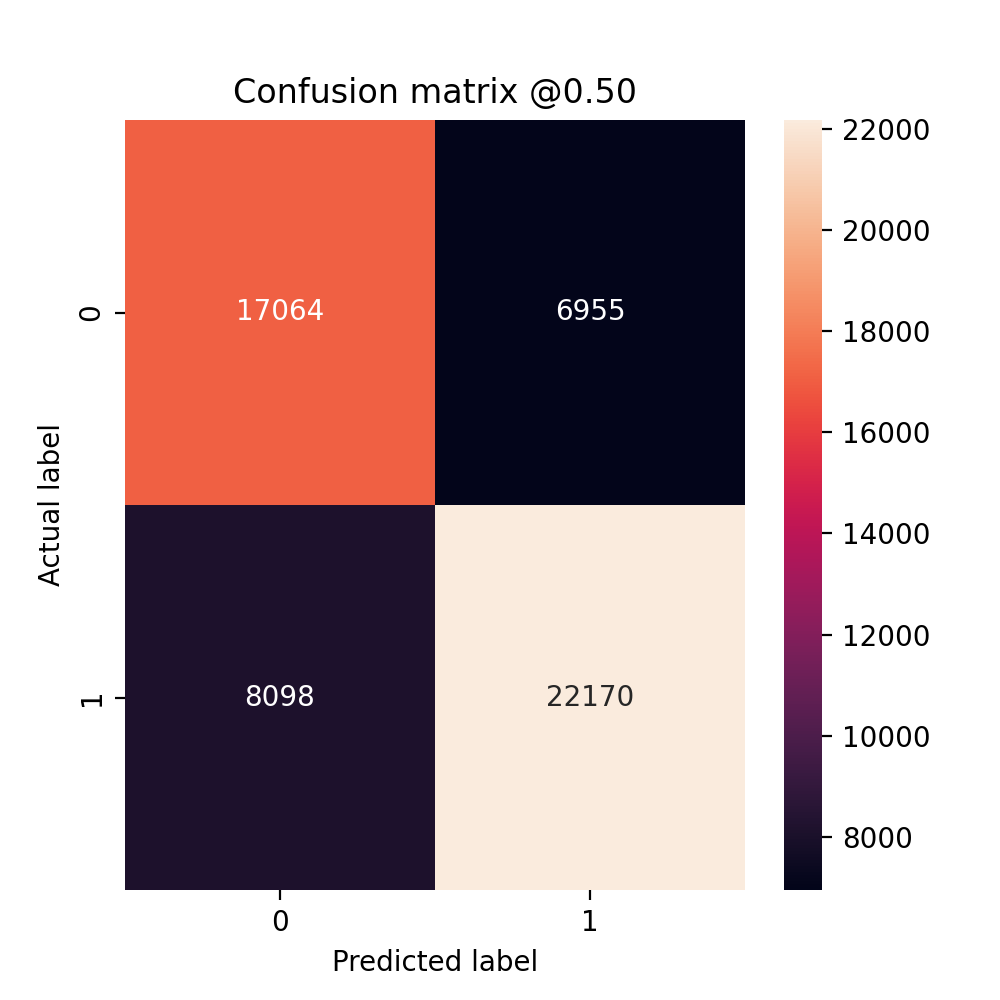

No Flow Detected (True Negatives):  17064
Flow Incorrectly Detected (False Positives):  6955
No Flow Incorrectly Detected (False Negatives):  8098
Flow Detected (True Positives):  22170
Total Flow Detected:  30268
0.7227144620258994


In [317]:
baseline.plot_cm()

### Resampling

In [780]:
def resample_(df_data, target = "Powder", n = 10000):
    grouped_df = df_data.groupby('Powder')
    # create a new dataframe to hold the resampled rows
    resampled_df = pd.DataFrame()

    # for each group in the grouped dataframe
    for name, group in grouped_df:
        # if the number of rows in the group is greater than n
        if len(group) > n:
            # undersample the group without replacement
            resampled_group = group.sample(n=n, replace=False)
        else:
            # oversample the group with replacement
            resampled_group = group.sample(n=n, replace=True)
        # append the resampled group to the resampled dataframe
        resampled_df = pd.concat([resampled_df, resampled_group], axis = 0)

    # print the resampled dataframe
    resampled_df = resampled_df.reset_index(drop = True)

    return resampled_df

In [781]:
resampled_df = resample_(df_data)


le = LabelEncoder()
resampled_df['Powder Class'] = le.fit_transform(resampled_df['Powder'])#type: ignore
num_classes = len(le.classes_)
counts = np.bincount(resampled_df['Powder Class']) 
total = sum(counts)

for label,count in zip(le.classes_,counts):
    print(f"Label {label} : {count} ({count/total * 100:.2f}% of total)")
    break

print(resampled_df)
resampled_df.pop('Powder')
resampled_df.pop('Flow Class')
resampled_df.pop('Flow')

class_labels = resampled_df.pop('Powder Class')

Label AEE_WP-301_1-5_AA_3-7.txt : 10000 (3.03% of total)
            Da      Dp  FWidth  FLength  ELength  EWidth     Volume      Area  \
0       40.873  49.168  27.426   58.012   59.990  28.417  35752.728  1312.090   
1       18.709  21.322  15.688   24.480   24.180  14.951   3428.737   274.903   
2       21.135  22.070  20.356   22.695   22.213  20.168   4943.430   350.841   
3        9.219  10.757   6.944   13.738   12.933   6.686    410.189    66.744   
4       17.568  20.941  14.499   23.817   24.240  13.545   2839.119   242.408   
...        ...     ...     ...      ...      ...     ...        ...       ...   
329995   7.083   7.518   6.905    7.960    7.594   6.538    186.095    39.408   
329996  26.623  33.258  22.965   35.913   33.019  22.614   9880.374   556.681   
329997  22.856  30.830  21.802   28.797   28.902  18.598   6251.634   410.286   
329998   8.247   9.379   6.197   11.470   10.636   6.448    293.715    53.421   
329999  12.033  12.913  11.621   13.774   12.836  11

## Flow Class Resample

In [782]:
powder_balanced_df = resample_(df_data)

powder_balanced_df.pop("Powder")
powder_balanced_df.pop("Flow")

neg, pos = np.bincount(powder_balanced_df['Flow Class']) #type: ignore
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 330000
    Positive: 240000 (72.73% of total)



In [321]:
balanced_model = Model(name = "Balanced Model", num_classes= 2)

balanced_model.split_transform_data(powder_balanced_df)

balanced_model.apply_StandardScaler()

Training labels shape: (211200,)
Validation labels shape: (52800,)
Test labels shape: (66000,)
Training features shape: (211200, 27)
Validation features shape: (52800, 27)
Test features shape: (66000, 27)


In [322]:
model = balanced_model.make_model()
history = balanced_model.fit_model()
# IPython.display.clear_output()
balanced_model.evaluate_model()

Epoch 1/100
104/104 [==============================] - 2s 9ms/step - loss: 0.5796 - tp: 223652.0000 - fp: 79303.0000 - tn: 55047.0000 - fn: 26914.0000 - accuracy: 0.7241 - precision: 0.7382 - recall: 0.8926 - auc: 0.7134 - prc: 0.8031 - val_loss: 0.5351 - val_tp: 38518.0000 - val_fp: 14282.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.7295 - val_precision: 0.7295 - val_recall: 1.0000 - val_auc: 0.7798 - val_prc: 0.9152
Epoch 2/100
104/104 [==============================] - 0s 2ms/step - loss: 0.5266 - tp: 151393.0000 - fp: 54540.0000 - tn: 2995.0000 - fn: 2272.0000 - accuracy: 0.7310 - precision: 0.7352 - recall: 0.9852 - auc: 0.7326 - prc: 0.8873 - val_loss: 0.5001 - val_tp: 38085.0000 - val_fp: 13561.0000 - val_tn: 721.0000 - val_fn: 433.0000 - val_accuracy: 0.7350 - val_precision: 0.7374 - val_recall: 0.9888 - val_auc: 0.7846 - val_prc: 0.9170
Epoch 3/100
104/104 [==============================] - 0s 2ms/step - loss: 0.5066 - tp: 147530.0000 - fp: 49891.0000 - tn:

Epoch 20/100
104/104 [==============================] - 0s 2ms/step - loss: 0.4755 - tp: 143956.0000 - fp: 44334.0000 - tn: 13201.0000 - fn: 9709.0000 - accuracy: 0.7441 - precision: 0.7645 - recall: 0.9368 - auc: 0.7795 - prc: 0.9119 - val_loss: 0.4598 - val_tp: 36380.0000 - val_fp: 11007.0000 - val_tn: 3275.0000 - val_fn: 2138.0000 - val_accuracy: 0.7510 - val_precision: 0.7677 - val_recall: 0.9445 - val_auc: 0.7936 - val_prc: 0.9199
Epoch 21/100
104/104 [==============================] - 0s 2ms/step - loss: 0.4751 - tp: 143866.0000 - fp: 43957.0000 - tn: 13578.0000 - fn: 9799.0000 - accuracy: 0.7455 - precision: 0.7660 - recall: 0.9362 - auc: 0.7804 - prc: 0.9123 - val_loss: 0.4594 - val_tp: 36361.0000 - val_fp: 10951.0000 - val_tn: 3331.0000 - val_fn: 2157.0000 - val_accuracy: 0.7517 - val_precision: 0.7685 - val_recall: 0.9440 - val_auc: 0.7939 - val_prc: 0.9200
Epoch 22/100
104/104 [==============================] - 0s 2ms/step - loss: 0.4750 - tp: 143676.0000 - fp: 43644.0000 - 

Epoch 39/100
104/104 [==============================] - 0s 2ms/step - loss: 0.4721 - tp: 143338.0000 - fp: 42997.0000 - tn: 14538.0000 - fn: 10327.0000 - accuracy: 0.7475 - precision: 0.7692 - recall: 0.9328 - auc: 0.7835 - prc: 0.9138 - val_loss: 0.4568 - val_tp: 36196.0000 - val_fp: 10639.0000 - val_tn: 3643.0000 - val_fn: 2322.0000 - val_accuracy: 0.7545 - val_precision: 0.7728 - val_recall: 0.9397 - val_auc: 0.7969 - val_prc: 0.9212
Epoch 40/100
104/104 [==============================] - 0s 2ms/step - loss: 0.4731 - tp: 143329.0000 - fp: 43196.0000 - tn: 14339.0000 - fn: 10336.0000 - accuracy: 0.7465 - precision: 0.7684 - recall: 0.9327 - auc: 0.7833 - prc: 0.9136 - val_loss: 0.4567 - val_tp: 36232.0000 - val_fp: 10678.0000 - val_tn: 3604.0000 - val_fn: 2286.0000 - val_accuracy: 0.7545 - val_precision: 0.7724 - val_recall: 0.9407 - val_auc: 0.7972 - val_prc: 0.9213
Epoch 41/100
104/104 [==============================] - 0s 2ms/step - loss: 0.4726 - tp: 143280.0000 - fp: 42971.0000 

Epoch 58/100
104/104 [==============================] - 0s 2ms/step - loss: 0.4718 - tp: 143133.0000 - fp: 42627.0000 - tn: 14908.0000 - fn: 10532.0000 - accuracy: 0.7483 - precision: 0.7705 - recall: 0.9315 - auc: 0.7848 - prc: 0.9143 - val_loss: 0.4557 - val_tp: 36273.0000 - val_fp: 10736.0000 - val_tn: 3546.0000 - val_fn: 2245.0000 - val_accuracy: 0.7541 - val_precision: 0.7716 - val_recall: 0.9417 - val_auc: 0.7983 - val_prc: 0.9217
Epoch 59/100
104/104 [==============================] - 0s 2ms/step - loss: 0.4717 - tp: 143182.0000 - fp: 42973.0000 - tn: 14562.0000 - fn: 10483.0000 - accuracy: 0.7469 - precision: 0.7692 - recall: 0.9318 - auc: 0.7846 - prc: 0.9143 - val_loss: 0.4554 - val_tp: 35968.0000 - val_fp: 10298.0000 - val_tn: 3984.0000 - val_fn: 2550.0000 - val_accuracy: 0.7567 - val_precision: 0.7774 - val_recall: 0.9338 - val_auc: 0.7981 - val_prc: 0.9216
Epoch 60/100
104/104 [==============================] - 0s 2ms/step - loss: 0.4715 - tp: 143273.0000 - fp: 42826.0000 

Epoch 77/100
104/104 [==============================] - 0s 2ms/step - loss: 0.4715 - tp: 143179.0000 - fp: 42829.0000 - tn: 14706.0000 - fn: 10486.0000 - accuracy: 0.7476 - precision: 0.7697 - recall: 0.9318 - auc: 0.7849 - prc: 0.9144 - val_loss: 0.4557 - val_tp: 36121.0000 - val_fp: 10589.0000 - val_tn: 3693.0000 - val_fn: 2397.0000 - val_accuracy: 0.7541 - val_precision: 0.7733 - val_recall: 0.9378 - val_auc: 0.7987 - val_prc: 0.9219
Epoch 78/100
104/104 [==============================] - 0s 2ms/step - loss: 0.4712 - tp: 143219.0000 - fp: 42774.0000 - tn: 14761.0000 - fn: 10446.0000 - accuracy: 0.7480 - precision: 0.7700 - recall: 0.9320 - auc: 0.7858 - prc: 0.9148 - val_loss: 0.4548 - val_tp: 36015.0000 - val_fp: 10404.0000 - val_tn: 3878.0000 - val_fn: 2503.0000 - val_accuracy: 0.7555 - val_precision: 0.7759 - val_recall: 0.9350 - val_auc: 0.7987 - val_prc: 0.9218
Epoch 79/100
104/104 [==============================] - 0s 2ms/step - loss: 0.4713 - tp: 143211.0000 - fp: 42680.0000 

<IPython.core.display.Javascript object>


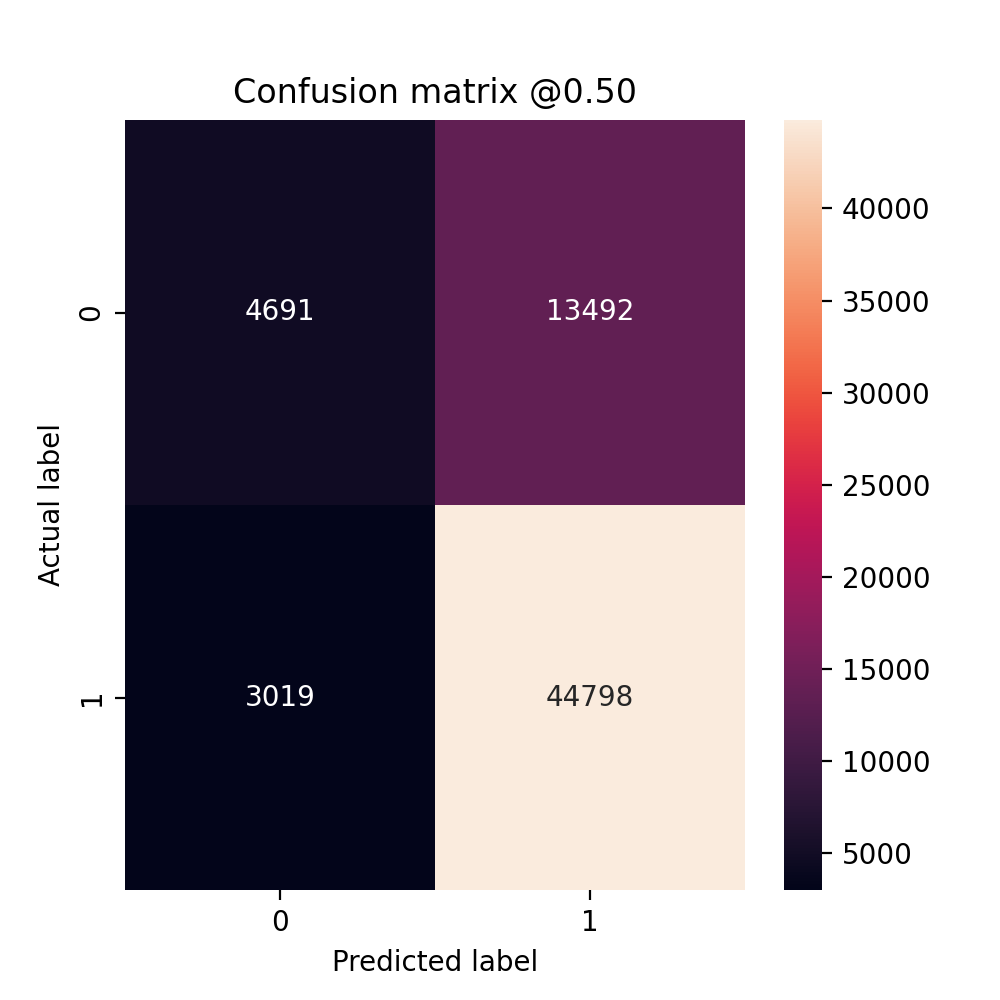

No Flow Detected (True Negatives):  4691
Flow Incorrectly Detected (False Positives):  13492
No Flow Incorrectly Detected (False Negatives):  3019
Flow Detected (True Positives):  44798
Total Flow Detected:  47817
0.7498333333333334


In [323]:
balanced_model.plot_cm()

## Let's try again

In [177]:
ae_model = Model(name = "Autoencoder Model", num_classes = 2)

ae_model.split_transform_data(powder_balanced_df)

ae_model.apply_StandardScaler()

train_x = balanced_model.train_features
## input layer 
input_layer = keras.Input(shape=(train_x.shape[1],))

## encoding part
encoded = keras.layers.Dense(100, activation='tanh', activity_regularizer=keras.regularizers.l1(10e-5))(input_layer)
encoded = keras.layers.Dense(50, activation='relu')(encoded)

## decoding part
decoded = keras.layers.Dense(50, activation='tanh')(encoded)
decoded = keras.layers.Dense(100, activation='tanh')(decoded)

## output layer
output_layer = keras.layers.Dense(train_x.shape[1], activation='relu')(decoded)

Training labels shape: (211200,)
Validation labels shape: (52800,)
Test labels shape: (66000,)
Training features shape: (211200, 27)
Validation features shape: (52800, 27)
Test features shape: (66000, 27)


In [178]:
from keras.models import Model, Sequential

autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

In [182]:
x = powder_balanced_df.drop(["Flow Class"], axis=1)
y = powder_balanced_df["Flow Class"].values
x_scale = MinMaxScaler().fit_transform(x.values)
x_norm, x_fraud = x_scale[y == 0], x_scale[y == 1]
x

,Da,Dp,FWidth,FLength,ELength,EWidth,Volume,Area,Perimeter,CHull Area,CHull Perimeter,Sphericity,Compactness,Roundness,Ellipse Ratio,Circularity,Solidity,Concavity,Convexity,Extent,Transparency,Curvature,Surface Area,L/W Ratio,W/L Aspect Ratio,CHull Surface Area,Ellipticity
0,15.802,23.060,14.934,25.210,22.388,12.996,2066.192,196.127,72.445,251.067,65.133,0.685,0.627,0.393,0.581,0.470,0.781,0.219,0.899,0.521,0.375,0.0,784.509,1.688,0.592,1004.266,1.723
1,7.921,10.762,7.290,13.781,10.341,6.370,260.265,49.283,33.810,58.736,32.294,0.736,0.575,0.330,0.616,0.542,0.839,0.161,0.955,0.491,0.389,0.0,197.134,1.890,0.529,234.944,1.623
2,9.847,10.999,8.059,13.049,12.899,7.639,499.869,76.149,34.554,79.516,34.369,0.895,0.755,0.569,0.592,0.801,0.958,0.042,0.995,0.724,0.379,0.0,304.594,1.619,0.618,318.064,1.689
3,10.260,11.020,9.309,12.573,11.978,8.792,565.478,82.674,34.620,85.432,34.237,0.931,0.816,0.666,0.734,0.867,0.968,0.032,0.989,0.706,0.386,0.0,330.695,1.351,0.740,341.729,1.362
4,11.722,13.077,9.809,15.066,14.450,9.587,843.362,107.920,41.083,114.306,39.903,0.896,0.778,0.605,0.663,0.804,0.944,0.056,0.971,0.730,0.360,0.0,431.678,1.536,0.651,457.222,1.507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329995,7.946,8.897,7.236,9.824,9.352,6.831,262.727,49.594,27.951,53.883,27.417,0.893,0.809,0.654,0.730,0.798,0.920,0.080,0.981,0.698,0.403,0.0,198.375,1.358,0.737,215.533,1.369
329996,13.336,13.863,12.972,14.348,13.624,13.092,1241.913,139.686,43.553,143.225,43.233,0.962,0.930,0.864,0.961,0.925,0.975,0.025,0.993,0.751,0.375,0.0,558.742,1.106,0.904,572.901,1.041
329997,16.538,17.203,15.565,18.249,18.093,15.138,2368.486,214.818,54.046,219.517,53.454,0.961,0.906,0.821,0.837,0.924,0.979,0.021,0.989,0.756,0.363,0.0,859.273,1.172,0.853,878.068,1.195
329998,12.192,15.656,12.295,14.560,13.738,10.919,948.881,116.743,49.186,136.659,42.702,0.779,0.837,0.701,0.795,0.606,0.854,0.146,0.868,0.652,0.406,0.0,466.973,1.184,0.844,546.635,1.258


In [183]:
autoencoder.fit(x_norm, x_norm, 
                batch_size = 256, epochs = 20, 
                shuffle = True, validation_split = 0.20);

Epoch 1/20
282/282 [==============================] - 1s 2ms/step - loss: 0.1703 - val_loss: 0.1473
Epoch 2/20
282/282 [==============================] - 0s 1ms/step - loss: 0.1582 - val_loss: 0.1339
Epoch 3/20
282/282 [==============================] - 0s 1ms/step - loss: 0.1413 - val_loss: 0.1194
Epoch 4/20
282/282 [==============================] - 0s 1ms/step - loss: 0.1257 - val_loss: 0.1068
Epoch 5/20
282/282 [==============================] - 0s 1ms/step - loss: 0.1124 - val_loss: 0.0964
Epoch 6/20
282/282 [==============================] - 0s 1ms/step - loss: 0.1015 - val_loss: 0.0881
Epoch 7/20
282/282 [==============================] - 0s 1ms/step - loss: 0.0930 - val_loss: 0.0820
Epoch 8/20
282/282 [==============================] - 0s 1ms/step - loss: 0.0867 - val_loss: 0.0777
Epoch 9/20
282/282 [==============================] - 0s 1ms/step - loss: 0.0824 - val_loss: 0.0750
Epoch 10/20
282/282 [==============================] - 0s 2ms/step - loss: 0.0796 - val_loss: 0.0734

In [184]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

In [193]:
print(x_norm.shape)
print(x_fraud.shape)
# norm_hid_rep = hidden_representation.predict(x_norm[:10000])
# fraud_hid_rep = hidden_representation.predict(x_fraud[:10000])
norm_hid_rep = hidden_representation.predict(x_norm[:10000])
fraud_hid_rep = hidden_representation.predict(x_fraud[:10000])
# norm_hid_rep = hidden_representation.predict(x_norm)
# fraud_hid_rep = hidden_representation.predict(x_fraud)

(90000, 27)
(240000, 27)


In [194]:
from sklearn.manifold import TSNE
import matplotlib.animation as animation

def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=3, random_state=0)
    X_t = tsne.fit_transform(x1)
    print(X_t)
    fig = plt.figure()
    
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(45,60)
    
#     print(X_t[np.where(y1 == 0), 0])
    plot_ = ax.scatter3D(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], X_t[np.where(y1 == 0), 2], marker='*', cmap='YlOrRd', alpha=0.8, label='No Flow')
    plot_ = ax.scatter3D(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], X_t[np.where(y1 == 1), 2], marker='o', cmap='BuPu', alpha=0.8, label='Flow')

#     plt.legend(loc='best');
#     plt.savefig(name);
    
    plt.show();
    
    
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)
print(rep_x.shape)
print(rep_y.shape)
# tsne_plot(rep_x, rep_y, "./latent_representation.png")



(20000, 50)
(20000,)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<IPython.core.display.Javascript object>


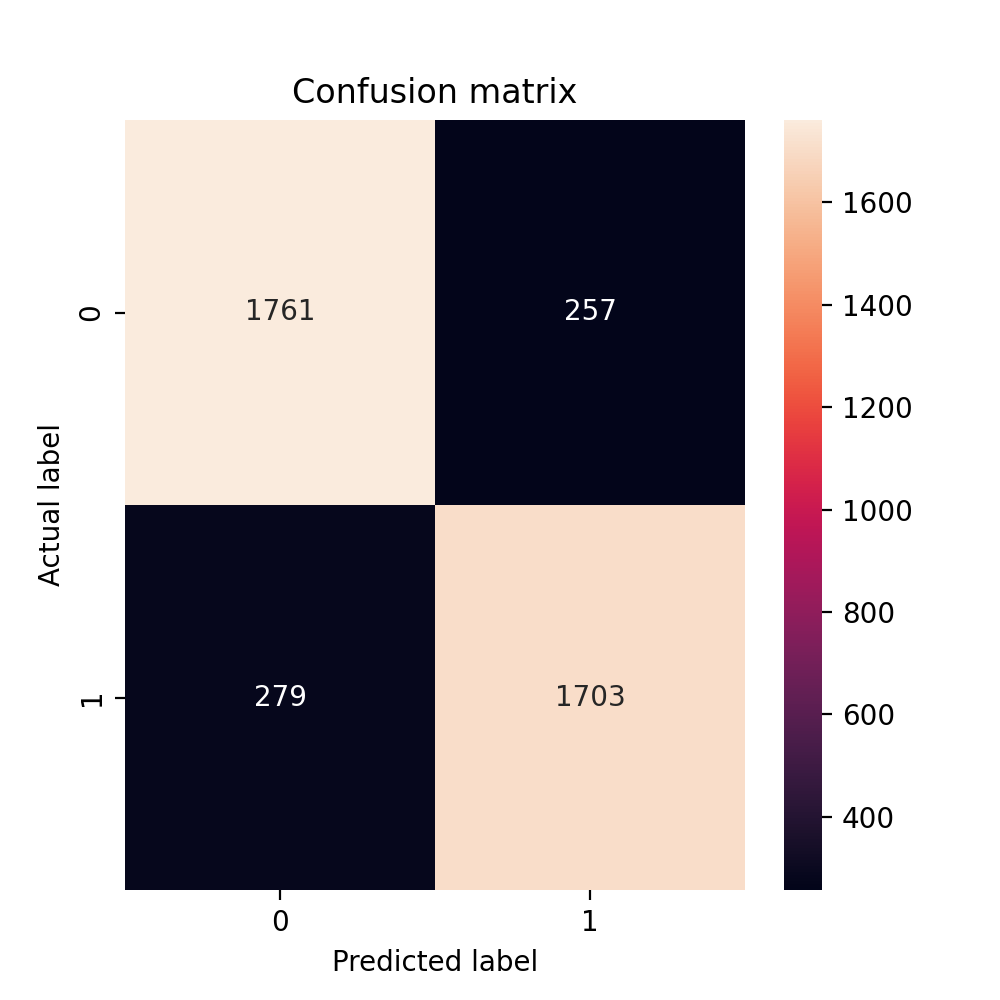

No Flow Detected (True Negatives):  1761
Flow Incorrectly Detected (False Positives):  257
No Flow Incorrectly Detected (False Negatives):  279
Flow Detected (True Positives):  1703
Total Flow Detected:  1982
0.866


In [195]:
from sklearn.linear_model import LogisticRegression

train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.2)

clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)

# print ("")
# print ("Classification Report: ")
# print (classification_report(val_y, pred_y))

# print ("")
# print ("Accuracy Score: ", accuracy_score(val_y, pred_y))

cm = confusion_matrix(val_y, pred_y)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print('No Flow Detected (True Negatives): ', cm[0][0])
print('Flow Incorrectly Detected (False Positives): ', cm[0][1])
print('No Flow Incorrectly Detected (False Negatives): ', cm[1][0])
print('Flow Detected (True Positives): ', cm[1][1])
print('Total Flow Detected: ', np.sum(cm[1]))
print((cm[0][0] + cm[1][1]) / (cm[0][0] +  cm[0][1] + cm[1][0] +cm[1][1]))

In [196]:
model = keras.Sequential([
          keras.layers.Dense(
              256, activation='tanh',
              input_shape=(train_x.shape[-1],)),
        keras.layers.Dense(
              128, activation='tanh'),
        keras.layers.Dense(
              64, activation='tanh'),
        keras.layers.Dense(
              32, activation='tanh'),
         keras.layers.Dense(
              16, activation='tanh'),
              keras.layers.Dense(
              8, activation='tanh'),
#           keras.layers.Dropout(0.5),
          keras.layers.Dense(1, activation='sigmoid'),
      ])

model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-4),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=['accuracy'])

model.fit(train_x,
    train_y,
    batch_size=1024,
    epochs=100)

results = model.evaluate(train_x, train_y, batch_size = 1024, verbose=0)


Epoch 1/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6803 - accuracy: 0.5744
Epoch 2/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6325 - accuracy: 0.7057
Epoch 3/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5912 - accuracy: 0.7305
Epoch 4/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5586 - accuracy: 0.7449
Epoch 5/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5314 - accuracy: 0.7585
Epoch 6/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5110 - accuracy: 0.7657
Epoch 7/100
16/16 [==============================] - 0s 4ms/step - loss: 0.4927 - accuracy: 0.7776
Epoch 8/100
16/16 [==============================] - 0s 5ms/step - loss: 0.4773 - accuracy: 0.7854
Epoch 9/100
16/16 [==============================] - 0s 4ms/step - loss: 0.4619 - accuracy: 0.7947
Epoch 10/100
16/16 [==============================] - 0s 4ms/step - loss: 0.4474 - accuracy: 0.8047
Epoch 11/

16/16 [==============================] - 0s 5ms/step - loss: 0.2653 - accuracy: 0.8898
Epoch 84/100
16/16 [==============================] - 0s 5ms/step - loss: 0.2651 - accuracy: 0.8885
Epoch 85/100
16/16 [==============================] - 0s 4ms/step - loss: 0.2637 - accuracy: 0.8891
Epoch 86/100
16/16 [==============================] - 0s 5ms/step - loss: 0.2655 - accuracy: 0.8879
Epoch 87/100
16/16 [==============================] - 0s 5ms/step - loss: 0.2624 - accuracy: 0.8903
Epoch 88/100
16/16 [==============================] - 0s 5ms/step - loss: 0.2624 - accuracy: 0.8898
Epoch 89/100
16/16 [==============================] - 0s 4ms/step - loss: 0.2638 - accuracy: 0.8896
Epoch 90/100
16/16 [==============================] - 0s 5ms/step - loss: 0.2671 - accuracy: 0.8849
Epoch 91/100
16/16 [==============================] - 0s 5ms/step - loss: 0.2644 - accuracy: 0.8886
Epoch 92/100
16/16 [==============================] - 0s 5ms/step - loss: 0.2639 - accuracy: 0.8877
Epoch 93/100


[[0.56 ]
 [0.111]
 [0.982]
 ...
 [0.941]
 [0.013]
 [0.888]]


<IPython.core.display.Javascript object>


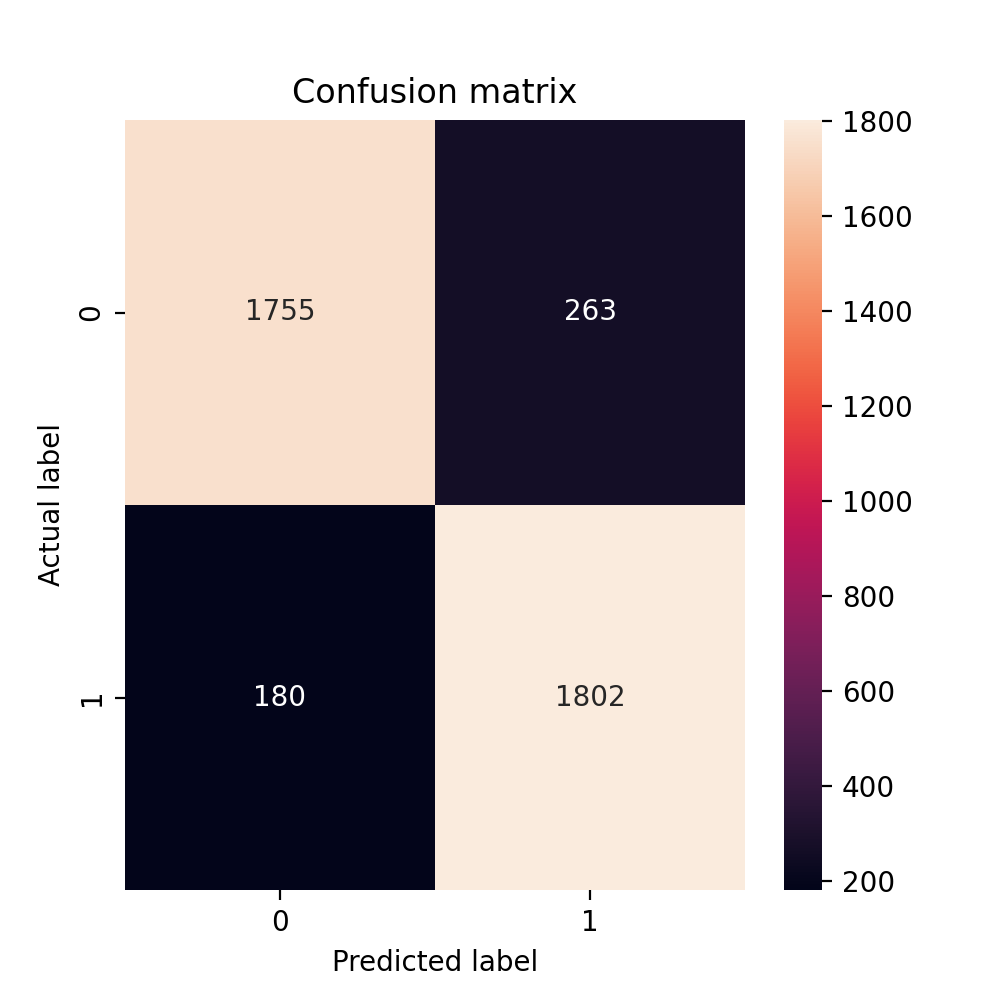

No Flow Detected (True Negatives):  1755
Flow Incorrectly Detected (False Positives):  263
No Flow Incorrectly Detected (False Negatives):  180
Flow Detected (True Positives):  1802
Total Flow Detected:  1982
0.88925


In [197]:
pred_y = model.predict(val_x)
print(pred_y)

cm = confusion_matrix(val_y, pred_y > 0.5)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print('No Flow Detected (True Negatives): ', cm[0][0])
print('Flow Incorrectly Detected (False Positives): ', cm[0][1])
print('No Flow Incorrectly Detected (False Negatives): ', cm[1][0])
print('Flow Detected (True Positives): ', cm[1][1])
print('Total Flow Detected: ', np.sum(cm[1]))
print((cm[0][0] + cm[1][1]) / (cm[0][0] +  cm[0][1] + cm[1][0] +cm[1][1]))

In [ ]:
import kerastuner as kt

def model_builder1(hp):
    # Initialize the Sequential API and start stacking the layers
#     model = keras.Sequential()
#     model.add(keras.layers.Flatten(input_shape=(27,)))
#     # Tune the number of units in the first Dense layer
#     # Choose an optimal value between 32-512
#     hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
#     model.add(keras.layers.Dense(units=hp_units, activation='relu', name='dense_1'))
#     # Add next layers
#     model.add(keras.layers.Dropout(0.2))
#     model.add(keras.layers.Dense(10, activation='softmax'))
#     # Tune the learning rate for the optimizer
#     # Choose an optimal value from 0.01, 0.001, or 0.0001
#     hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
#     model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
#                 loss=keras.losses.SparseCategoricalCrossentropy(),
#                 metrics=['accuracy'])
    model = keras.Sequential([
          keras.layers.Dense(
              256, activation=hp.Choice('act_0', ['relu', 'sigmoid', 'tanh']),
              input_shape=(train_x.shape[-1],)),
        keras.layers.Dense(
              128, activation=hp.Choice('act_1', ['relu', 'sigmoid', 'tanh'])),
        keras.layers.Dense(
              64, activation=hp.Choice('act_2', ['relu', 'sigmoid', 'tanh'])),
        keras.layers.Dense(
              32, activation=hp.Choice('act_3', ['relu', 'sigmoid', 'tanh'])),
         keras.layers.Dense(
              16, activation=hp.Choice('act_4', ['relu', 'sigmoid', 'tanh'])),
              keras.layers.Dense(
              8, activation=hp.Choice('act_5', ['relu', 'sigmoid', 'tanh'])),
#           keras.layers.Dropout(0.5),
          keras.layers.Dense(1, activation=hp.Choice('act_6', ['relu', 'sigmoid', 'tanh']))
              ])
    model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=['accuracy'])
    return model

In [ ]:
# Instantiate the tuner
tuner = kt.Hyperband(model_builder1, # the hypermodel
                     objective='val_accuracy', # objective to optimize
                        max_epochs=20,
                        factor=3, # factor which you have seen above 
                        directory='dir/f2n', # directory to save logs 
                        project_name='hyperband')

# hypertuning settings
tuner.search_space_summary() 

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# Perform hypertuning
tuner.search(train_x, train_y, epochs=10, validation_split=0.2, callbacks=[stop_early])

In [ ]:
best_hp=tuner.get_best_hyperparameters()[0]# Build the model with the optimal hyperparameters

In [ ]:
h_model = tuner.hypermodel.build(best_hp)
h_model.summary()
h_model.fit(train_x, train_y, epochs=50, validation_split=0.2)

In [ ]:
h_eval_dict = h_model.evaluate(val_x, val_y, return_dict=True)

In [ ]:
pred_y = h_model.predict(val_x)
print(pred_y)

cm = confusion_matrix(val_y, pred_y > 0.5)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print('No Flow Detected (True Negatives): ', cm[0][0])
print('Flow Incorrectly Detected (False Positives): ', cm[0][1])
print('No Flow Incorrectly Detected (False Negatives): ', cm[1][0])
print('Flow Detected (True Positives): ', cm[1][1])
print('Total Flow Detected: ', np.sum(cm[1]))
print((cm[0][0] + cm[1][1]) / (cm[0][0] +  cm[0][1] + cm[1][0] +cm[1][1]))

## Please WORK!

In [871]:
# manual parameter 
RATIO_TO_FRAUD = 15

# splitting by class
flow = powder_balanced_df[powder_balanced_df["Flow Class"] == 1]
noflow = powder_balanced_df[powder_balanced_df["Flow Class"] == 0]

print(flow.shape)
print(noflow.shape)

# undersample clean transactions
flow_undersample = flow.sample(90000,
    random_state=123
)

print(flow_undersample.shape)
print(noflow.shape)
# concatenate with fraud transactions into a single dataframe
visualisation_initial = pd.concat([noflow, flow_undersample])
column_names = list(visualisation_initial.drop('Flow Class', axis=1).columns)

# isolate features from labels 
features, labels = visualisation_initial.drop('Flow Class', axis=1).values, \
                   visualisation_initial["Flow Class"].values
print(features.shape)

(240000, 28)
(90000, 28)
(90000, 28)
(90000, 28)
(180000, 27)


In [527]:
print(f"""The non-fraud dataset has been undersampled from {len(flow):,} to {len(flow_undersample):,}.""")

The non-fraud dataset has been undersampled from 240,000 to 90,000.


In [870]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

def tsne_scatter(features, labels, dimensions=2, save_as='graph.png'):
    if dimensions not in (2, 3):
        raise ValueError('tsne_scatter can only plot in 2d or 3d (What are you? An alien that can visualise >3d?). Make sure the "dimensions" argument is in (2, 3)')
    feature_first = features[:10000]
    feature_second = features[120000:]
    # t-SNE dimensionality reduction
    features_embedded1 = TSNE(n_components=dimensions, random_state=123).fit_transform(flow[:10000])
    features_embedded2 = TSNE(n_components=dimensions, random_state=123).fit_transform(noflow[:10000])

    # initialising the plot
    fig, ax = plt.subplots(figsize=(8,8))
    
    # counting dimensions
    if dimensions == 3: ax = fig.add_subplot(111, projection='3d')
    # plotting data
    ax.scatter(
        *zip(*features_embedded1),
        marker='o',
        color='orange',
        s=2,
        alpha=0.7,
        label='Flow'
    )
    ax.scatter(
        *zip(*features_embedded2),
        marker='o',
        color='blue',
        s=2,
        alpha=0.3,
        label='No Flow'
    )

    # storing it to be displayed later
    plt.legend(loc='best')
    plt.savefig(save_as);
    plt.show;

(130000, 27)
(10000, 27)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<IPython.core.display.Javascript object>


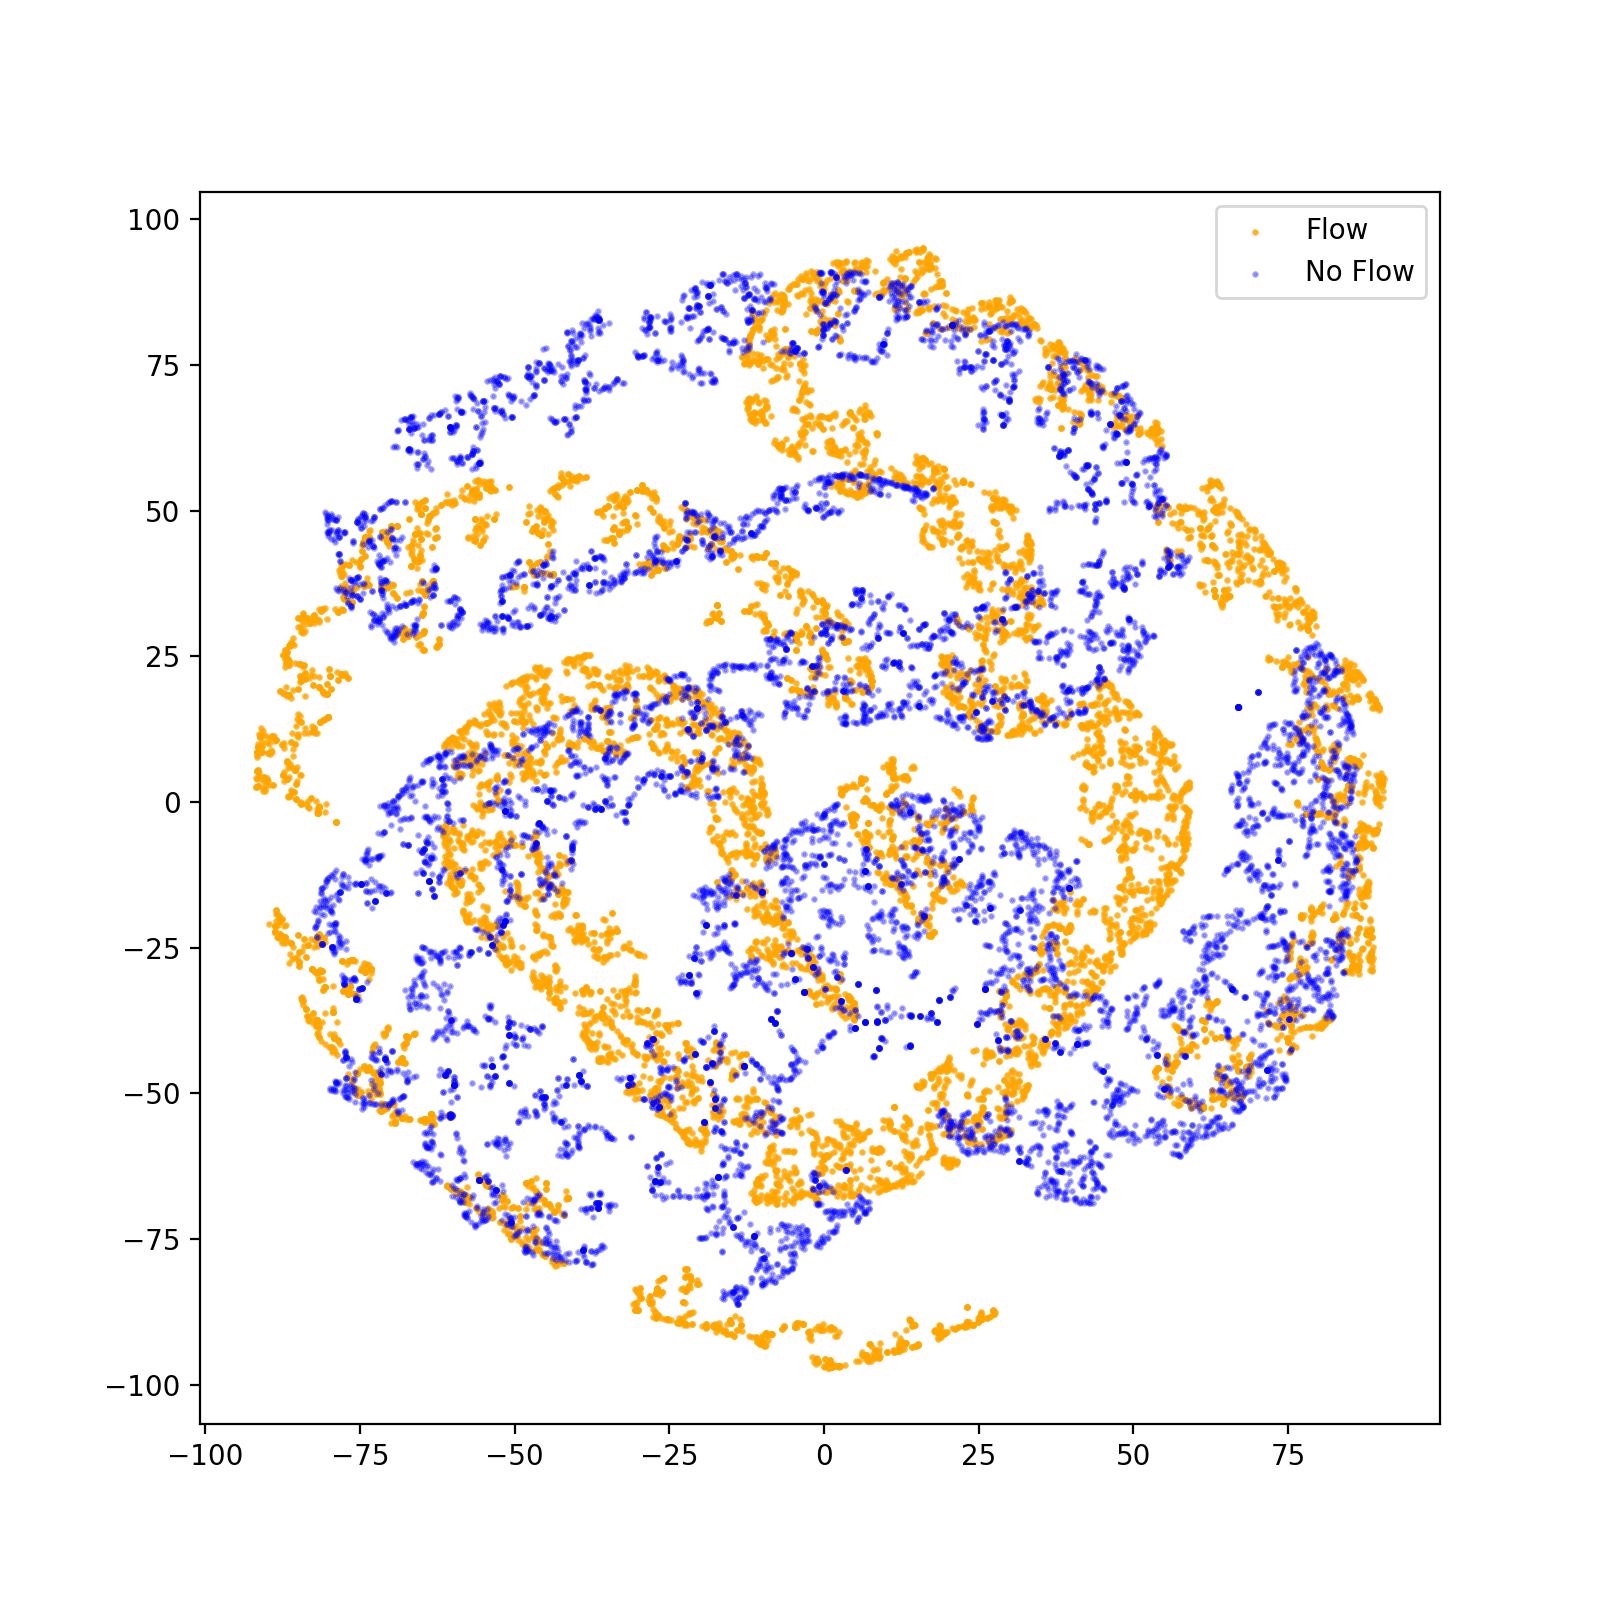

In [834]:
print(features.shape)
tsne_scatter(features, labels, dimensions=2, save_as='tsne_initial_2d.png')

In [840]:
print(f"""Shape of the datasets:
    Flow (rows, cols) = {flow.shape}
    Noflow (rows, cols) = {noflow.shape}""")

Shape of the datasets:
    Flow (rows, cols) = (40000, 27)
    Noflow (rows, cols) = (90000, 27)


In [843]:
# shuffle our training set
# flow = flow.sample(frac=1).reset_index(drop=True)
# print(flow.shape)
# print(noflow.shape)
# y_train = noflow.iloc[70000:]["Flow Class"]
# y_test = flow.iloc[150000:].append(noflow).sample(frac=1)["Flow Class"]
# # training set: exlusively non-fraud transactions
# X_train = noflow.iloc[:70000].drop('Flow Class', axis=1)
# # testing  set: the remaining non-fraud + all the fraud 
# X_test = flow.iloc[:150000].append(noflow).sample(frac=1)



# shuffle our training set
flow = flow.sample(frac=1).reset_index(drop=True)

# training set: exlusively non-fraud transactions

X_train = flow.iloc[:200000].drop('Flow Class', axis=1)

# testing  set: the remaining non-fraud + all the fraud 
X_test = flow.iloc[200000:].append(noflow).sample(frac=1)

In [844]:
print(f"""Our testing set is composed as follows:

{X_test["Flow Class"].value_counts()}""")


Our testing set is composed as follows:

0    90000
1    40000
Name: Flow Class, dtype: int64


In [845]:
from sklearn.model_selection import train_test_split

# train // validate - no labels since they're all clean anyway
X_train, X_validate = train_test_split(X_train,
                                       test_size=0.2, 
                                       random_state=123)
# manually splitting the labels from the test df
X_test, y_test = X_test.drop('Flow Class', axis=1).values, X_test["Flow Class"].values

In [846]:
print(f"""Shape of the datasets:
    train (rows, cols) = {X_train.shape}
    validate (rows, cols) = {X_validate.shape}
    test  (rows, cols) = {X_test.shape}""")

Shape of the datasets:
    train (rows, cols) = (160000, 27)
    validate (rows, cols) = (40000, 27)
    test  (rows, cols) = (130000, 27)


In [847]:
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline

# configure our pipeline
pipeline = Pipeline([('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])

In [848]:
# get normalization parameters by fitting to the training data
pipeline.fit(X_train);

In [849]:
# transform the training and validation data with these parameters
X_train_transformed = pipeline.transform(X_train)
X_validate_transformed = pipeline.transform(X_validate)

<IPython.core.display.Javascript object>


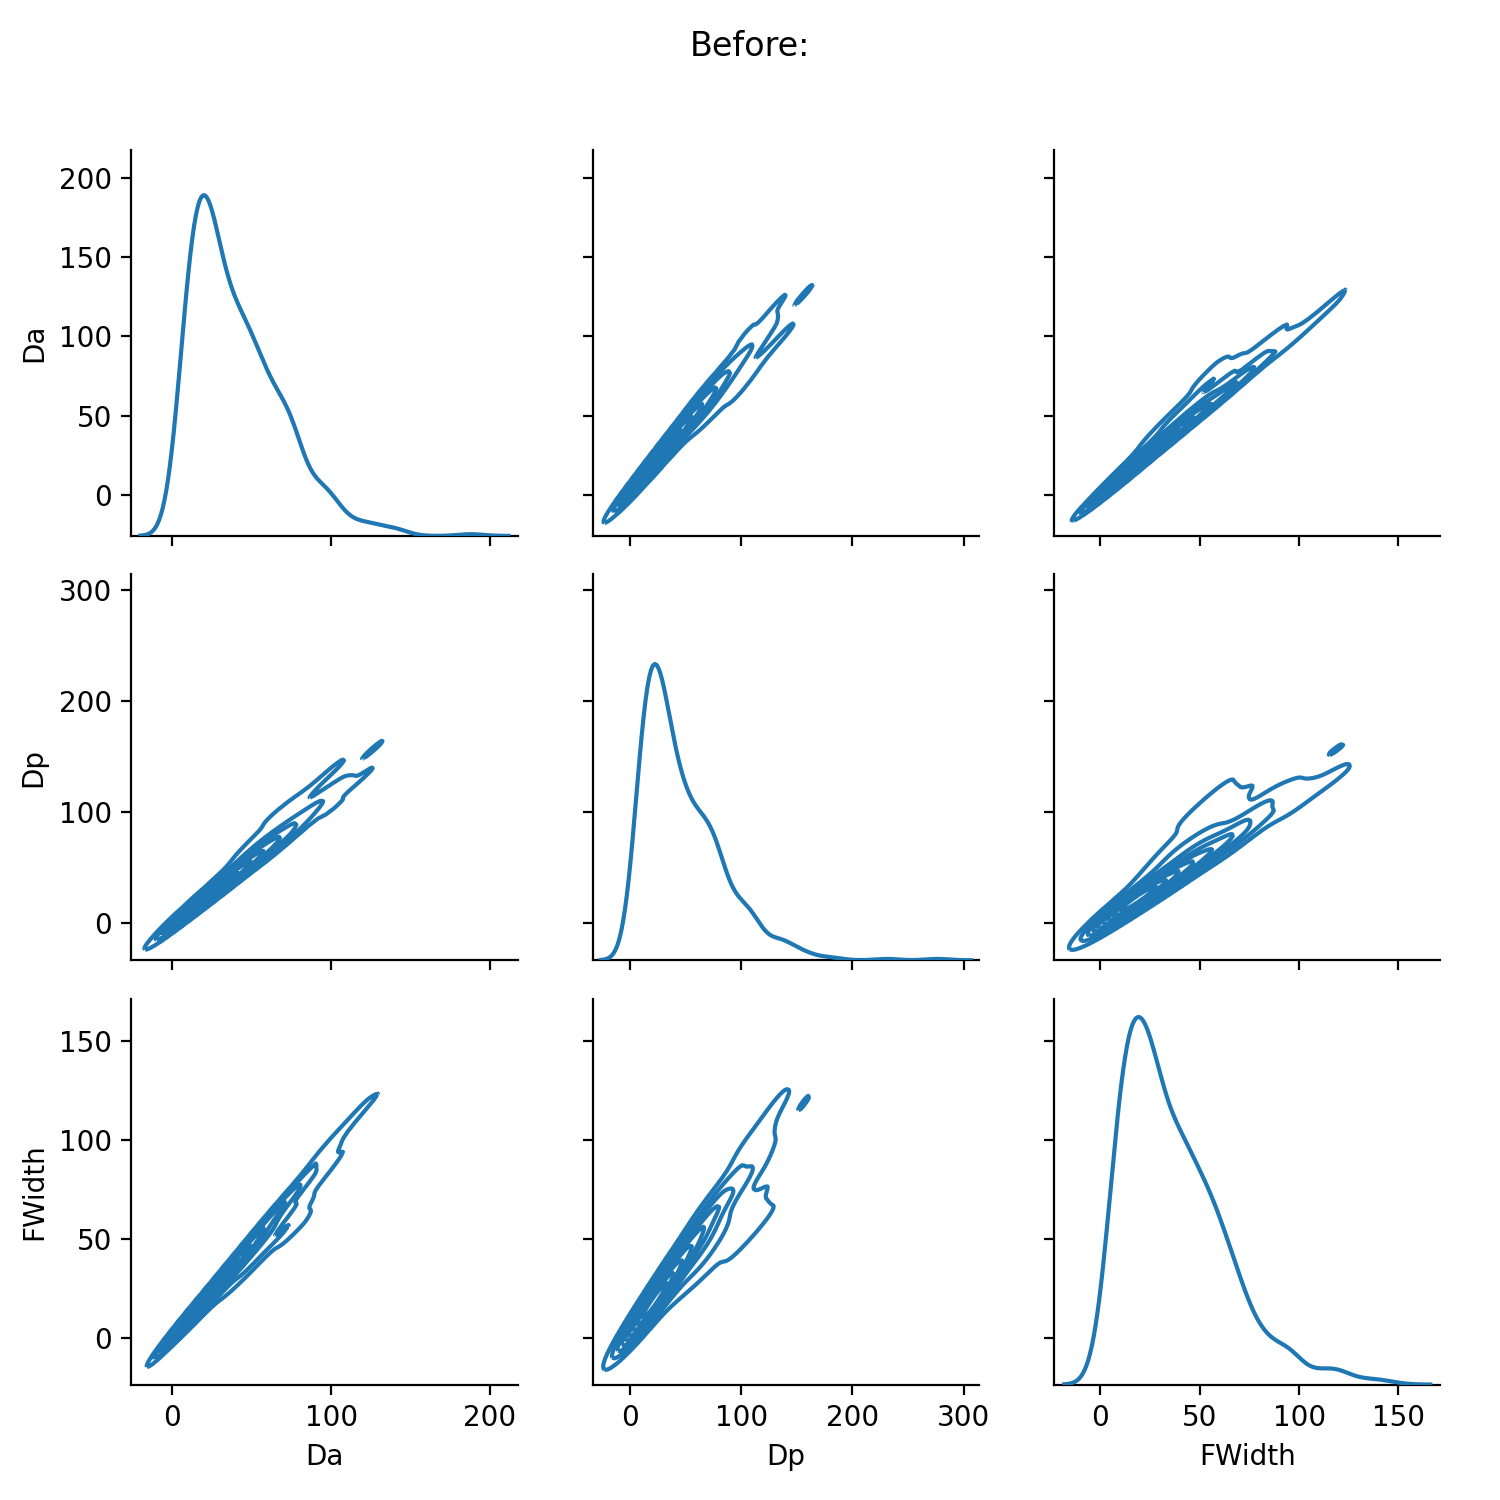

In [850]:
g = sns.PairGrid(X_train.iloc[:,:3].sample(600, random_state=77))
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Before:')
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot);

<IPython.core.display.Javascript object>


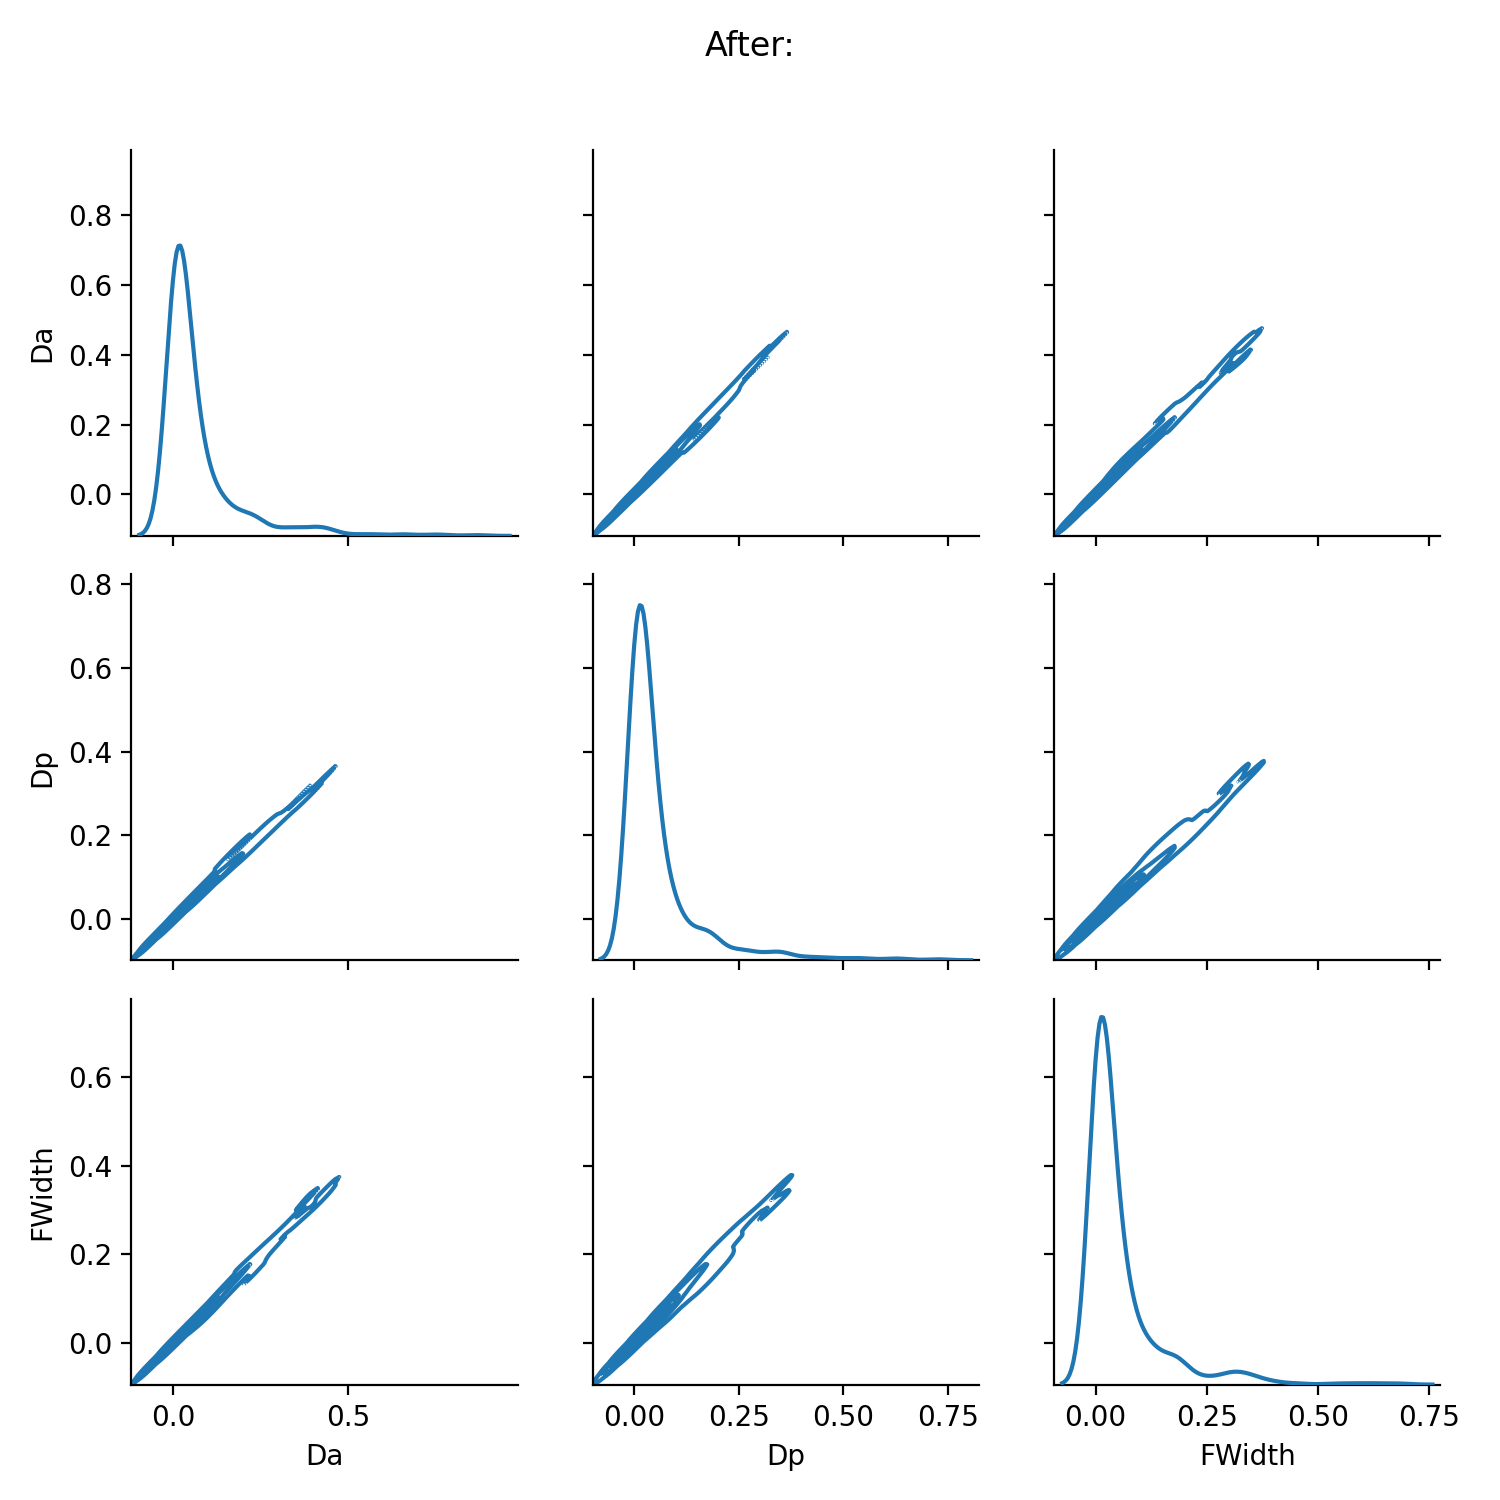

In [851]:
g = sns.PairGrid(pd.DataFrame(X_train_transformed, columns=column_names).iloc[:,:3].sample(600, random_state=77))
plt.subplots_adjust(top=0.9)
g.fig.suptitle('After:')
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot);


In [ ]:
# # Load the extension and start TensorBoard
# %load_ext tensorboard
# %tensorboard --logdir logs

In [918]:
# data dimensions // hyperparameters 
input_dim = X_train_transformed.shape[1]
BATCH_SIZE = 256
EPOCHS = 100

# https://keras.io/layers/core/
autoencoder = tf.keras.models.Sequential([
    
    # deconstruct / encode
    tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )), 
    tf.keras.layers.Dense(16, activation='elu'),
    tf.keras.layers.Dense(8, activation='elu'),
    tf.keras.layers.Dense(4, activation='elu'),
    tf.keras.layers.Dense(3, activation='elu'),
    
    # reconstruction / decode
    tf.keras.layers.Dense(4, activation='elu'),
    tf.keras.layers.Dense(8, activation='elu'),
    tf.keras.layers.Dense(16, activation='elu'),
    tf.keras.layers.Dense(input_dim, activation='elu')
    
])

# https://keras.io/api/models/model_training_apis/
autoencoder.compile(optimizer="adam", 
                    loss="mse",
                    metrics=["acc"])

# print an overview of our model
autoencoder.summary();

Model: "sequential_72"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_394 (Dense)           (None, 27)                756       
                                                                 
 dense_395 (Dense)           (None, 16)                448       
                                                                 
 dense_396 (Dense)           (None, 8)                 136       
                                                                 
 dense_397 (Dense)           (None, 4)                 36        
                                                                 
 dense_398 (Dense)           (None, 3)                 15        
                                                                 
 dense_399 (Dense)           (None, 4)                 16        
                                                                 
 dense_400 (Dense)           (None, 8)               

In [919]:
from datetime import datetime

# current date and time
yyyymmddHHMM = datetime.now().strftime('%Y%m%d%H%M')

# new folder for a new run
log_subdir = f'{yyyymmddHHMM}_batch{BATCH_SIZE}_layers{len(autoencoder.layers)}'

# define our early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True
)

save_model = tf.keras.callbacks.ModelCheckpoint(
    filepath='autoencoder_best_weights.hdf5',
    save_best_only=True,
    monitor='val_loss',
    verbose=0,
    mode='min'
)

tensorboard = tf.keras.callbacks.TensorBoard(
    f'logs/{log_subdir}',
    batch_size=BATCH_SIZE,
    update_freq='batch'
)

# callbacks argument only takes a list
cb = [early_stop, save_model, tensorboard]


In [920]:
history = autoencoder.fit(
    X_train_transformed, X_train_transformed,
    shuffle=True,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=cb,
    validation_data=(X_validate_transformed, X_validate_transformed)
);

Epoch 1/100
625/625 [==============================] - 2s 2ms/step - loss: 0.0041 - acc: 0.9272 - val_loss: 1.7164e-04 - val_acc: 0.9542
Epoch 2/100
625/625 [==============================] - 1s 2ms/step - loss: 1.1672e-04 - acc: 0.9558 - val_loss: 1.0433e-04 - val_acc: 0.9557
Epoch 3/100
625/625 [==============================] - 1s 2ms/step - loss: 9.2869e-05 - acc: 0.9550 - val_loss: 9.0903e-05 - val_acc: 0.9542
Epoch 4/100
625/625 [==============================] - 1s 1ms/step - loss: 7.6593e-05 - acc: 0.9550 - val_loss: 7.0781e-05 - val_acc: 0.9554
Epoch 5/100
625/625 [==============================] - 1s 1ms/step - loss: 5.8178e-05 - acc: 0.9582 - val_loss: 5.5701e-05 - val_acc: 0.9589
Epoch 6/100
625/625 [==============================] - 1s 1ms/step - loss: 4.9444e-05 - acc: 0.9591 - val_loss: 4.9608e-05 - val_acc: 0.9605
Epoch 7/100
625/625 [==============================] - 1s 1ms/step - loss: 4.5430e-05 - acc: 0.9591 - val_loss: 4.6697e-05 - val_acc: 0.9592
Epoch 8/100
625/6

In [990]:
# transform the test set with the pipeline fitted to the training set
X_test_transformed = pipeline.transform(X_test)

# pass the transformed test set through the autoencoder to get the reconstructed result
reconstructions = autoencoder.predict(X_test_transformed)
# calculating the mean squared error reconstruction loss per row in the numpy array
flow_mse = np.mean(np.power(X_test_transformed - reconstructions, 2), axis=1)
flow_mse

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  warnings.warn(


array([0.   , 0.   , 0.   , ..., 0.   , 0.002, 0.   ])

In [992]:
np.max(flow_mse)

0.1470948747227113

In [993]:
noflow_transformed = pipeline.transform(noflow)
reconstructions_no = autoencoder.predict(noflow_transformed)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  warnings.warn(


In [994]:
noflow_transformed = pipeline.transform(noflow)
reconstructions_no = autoencoder.predict(noflow_transformed)
noflow_mse = np.mean(np.power(noflow - reconstructions_no, 2), axis=1)
noflow_mse

array([ 0.042,  0.237,  0.054, ...,  0.087, 13.865,  0.034])

In [995]:
np.mean(noflow_mse)

2.1017054135469113

<IPython.core.display.Javascript object>


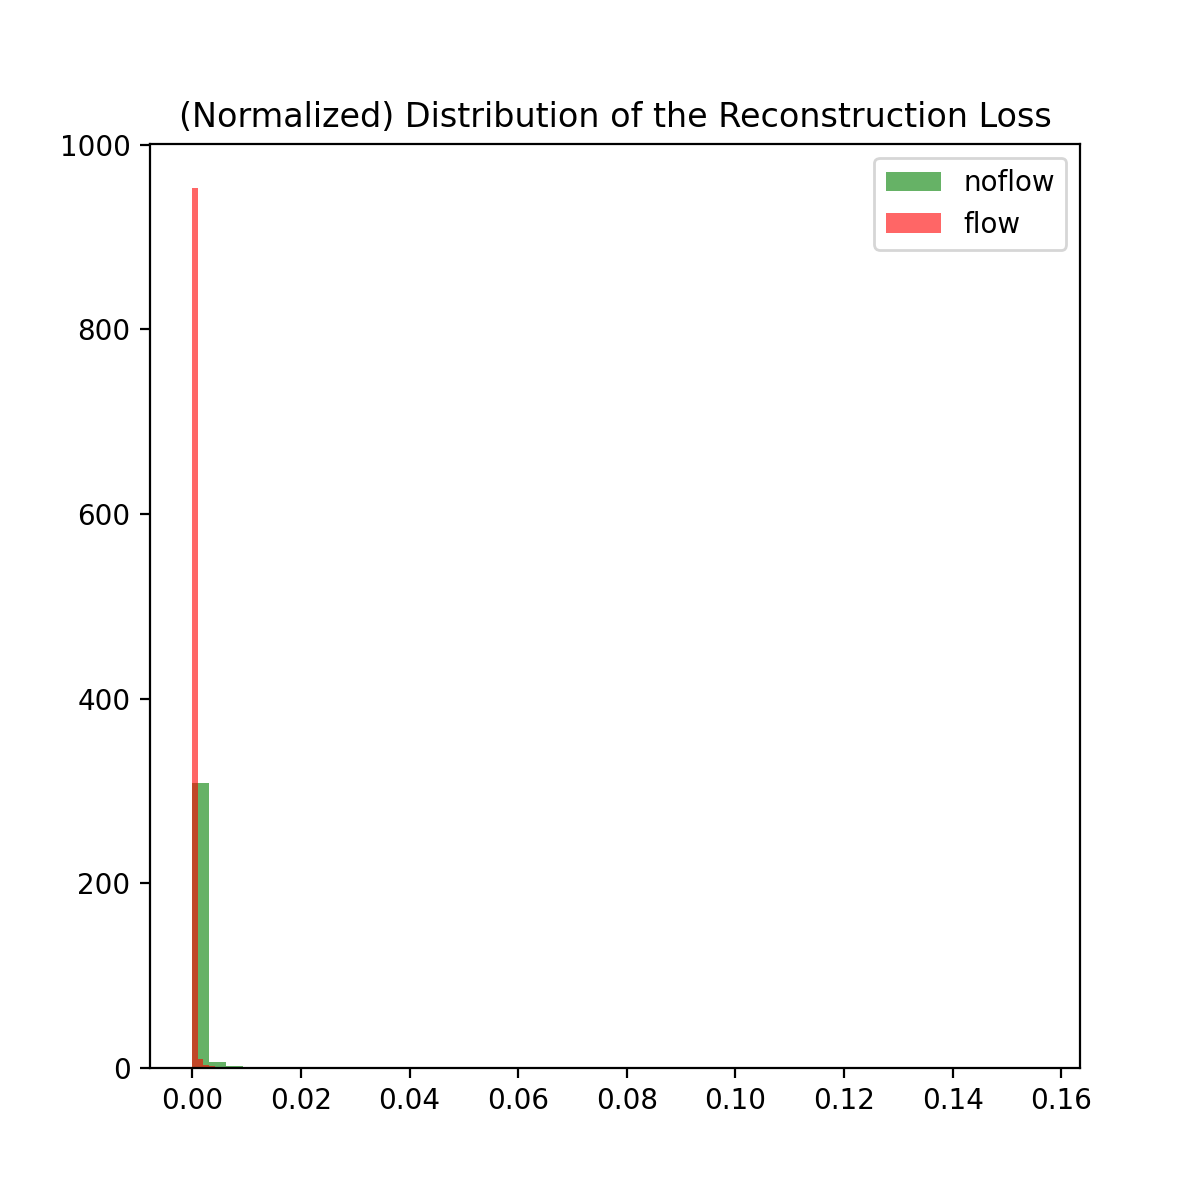

In [859]:
noflow = mse[y_test==0]
flow = mse[y_test==1]

fig, ax = plt.subplots(figsize=(6,6))

ax.hist(noflow, bins=50, density=True, label="noflow", alpha=.6, color="green")
ax.hist(flow, bins=50, density=True, label="flow", alpha=.6, color="red")

plt.title("(Normalized) Distribution of the Reconstruction Loss")
plt.legend()
plt.show()

In [861]:
THRESHOLD = 2

def mad_score(points):
    """https://www.itl.nist.gov/div898/handbook/eda/section3/eda35h.htm """
    m = np.median(points)
    ad = np.abs(points - m)
    mad = np.median(ad)
    
    return 0.6745 * ad / mad

z_scores = mad_score(mse)
outliers = z_scores > THRESHOLD

In [862]:
print(f"Detected {np.sum(outliers):,} outliers in a total of {np.size(z_scores):,} particles [{np.sum(outliers)/np.size(z_scores):.2%}].")

Detected 36,738 outliers in a total of 130,000 particles [28.26%].


In [863]:
from sklearn.metrics import (confusion_matrix, 
                             precision_recall_curve)

# get (mis)classification
cm = confusion_matrix(y_test, outliers)

# true/false positives/negatives
(tn, fp, 
 fn, tp) = cm.flatten()

In [864]:
print(f"""The classifications using the MAD method with threshold={THRESHOLD} are as follows:
{cm}

% of transactions labeled as noflow that were correct (precision): {tp}/({fp}+{tp}) = {tp/(fp+tp):.2%}
% of noflow particles were caught succesfully (recall):    {tp}/({fn}+{tp}) = {tp/(fn+tp):.2%}""")

The classifications using the MAD method with threshold=2 are as follows:
[[57193 32807]
 [36069  3931]]

% of transactions labeled as noflow that were correct (precision): 3931/(32807+3931) = 10.70%
% of noflow particles were caught succesfully (recall):    3931/(36069+3931) = 9.83%


<IPython.core.display.Javascript object>


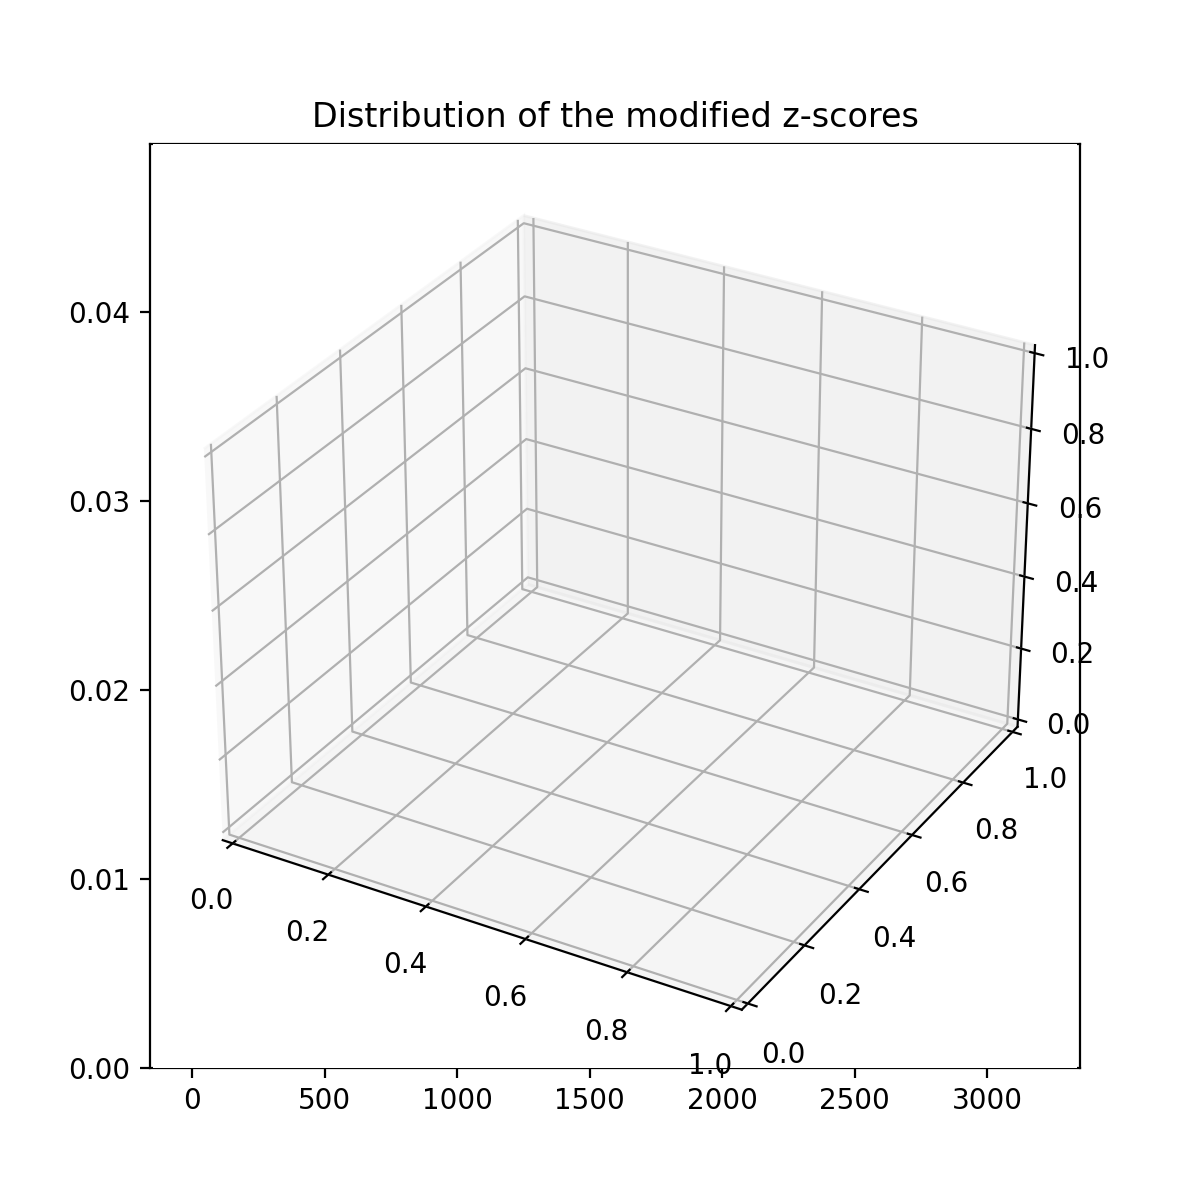

In [865]:
noflow = z_scores[y_test==0]
flow = z_scores[y_test==1]

fig, ax = plt.subplots(figsize=(6,6))

ax.hist(noflow, bins=50, density=True, label="noflow", alpha=.6, color="green")
ax.hist(flow, bins=50, density=True, label="flow", alpha=.6, color="red")

plt.title("Distribution of the modified z-scores")
plt.legend()
plt.show()

In [921]:
encoder = tf.keras.models.Sequential(autoencoder.layers[:5])
encoder.summary()

Model: "sequential_73"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_394 (Dense)           (None, 27)                756       
                                                                 
 dense_395 (Dense)           (None, 16)                448       
                                                                 
 dense_396 (Dense)           (None, 8)                 136       
                                                                 
 dense_397 (Dense)           (None, 4)                 36        
                                                                 
 dense_398 (Dense)           (None, 3)                 15        
                                                                 
Total params: 1,391
Trainable params: 1,391
Non-trainable params: 0
_________________________________________________________________


In [957]:
# taking all the fraud, undersampling clean
print(flow.shape)
print(noflow.shape)
flow = features[labels==1]
noflow = features[labels==0]
print(flow.shape)
print(noflow.shape)

maj_class1 = resample(flow, 
                                 replace=True,     
                                 n_samples=20000,    
                                 random_state=123) 
maj_class2 = resample(noflow, 
                                 replace=True,     
                                 n_samples=20000,    
                                 random_state=123) 
df=np.concatenate([maj_class1,maj_class2])


# combining arrays & building labels
# train_features = np.append(flow, noflow, axis=0)
train_labels = np.append(np.ones(len(maj_class1)),
                   np.zeros(len(maj_class2)))

# getting latent space representation
latent_representation = encoder.predict(df)

# print(f'Clean transactions downsampled from {len(X_test_transformed[y_test==0]):,} to {len(flow):,}.')
print('Shape of latent representation:', latent_representation.shape)

(40000, 27)
(90000, 27)
(40000, 27)
(90000, 27)
Shape of latent representation: (40000, 3)


<IPython.core.display.Javascript object>


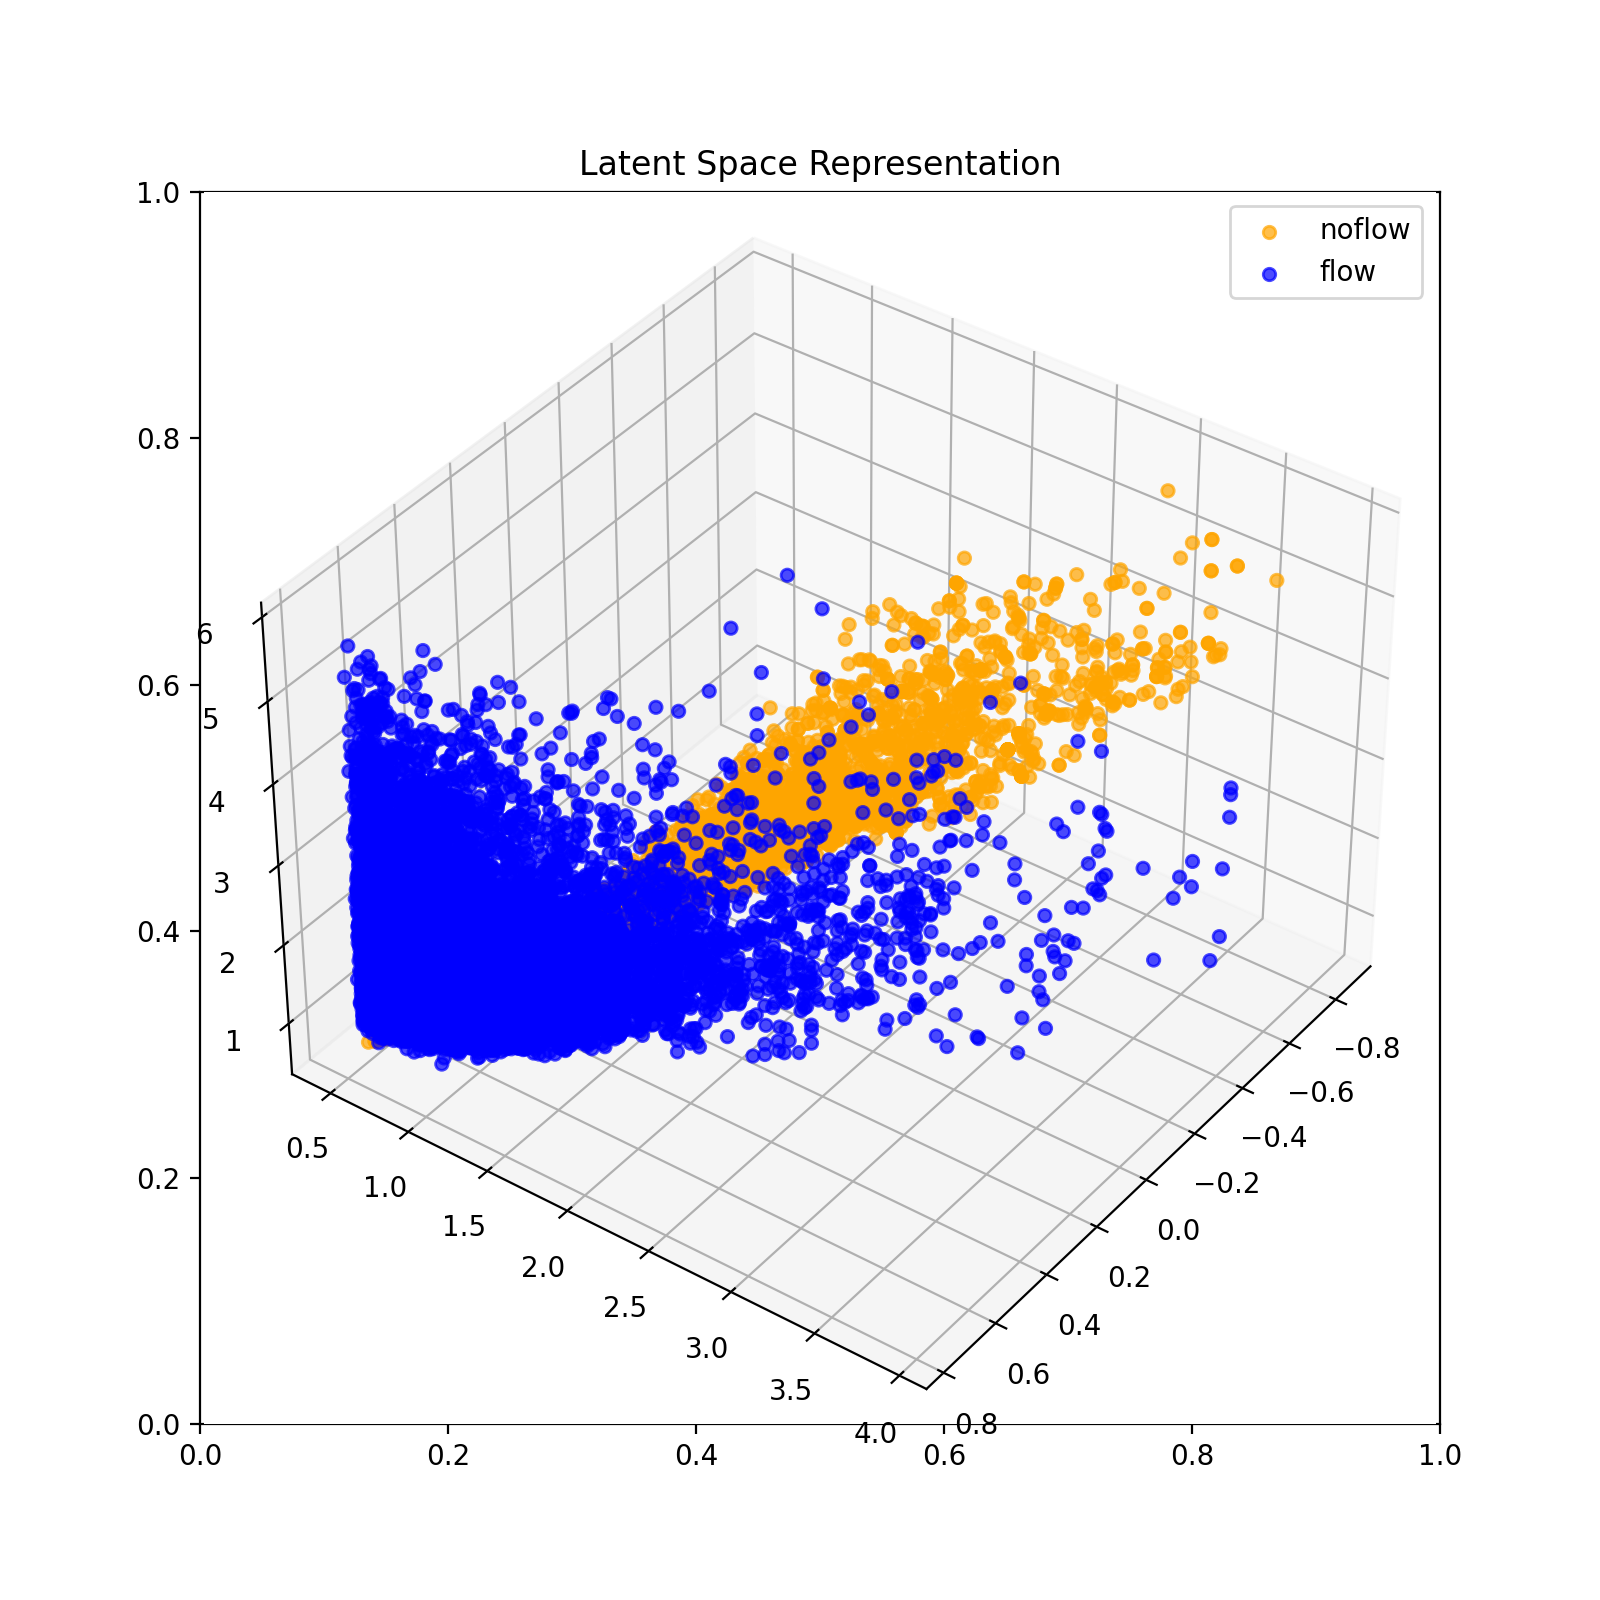

In [958]:
X = latent_representation[:,0]
y = latent_representation[:,1]
z = latent_representation[:,2]

# plotting
fig, ax = plt.subplots(figsize=(8,8))
    

ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[train_labels==0], y[train_labels==0], z[train_labels==0], c='orange', alpha=0.7, label='noflow')
ax.scatter(X[train_labels==1], y[train_labels==1], z[train_labels==0], c='blue', alpha=0.7, label='flow')

# labeling
plt.legend(loc='best')
plt.title('Latent Space Representation')

# saving & displaying
plt.savefig('latent_representation_2d');
plt.show()


(40000, 27)
(90000, 27)
130000
130000
(72071, 3)
(31929, 3)
(30000, 3)
(30000, 3)
[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]


<IPython.core.display.Javascript object>


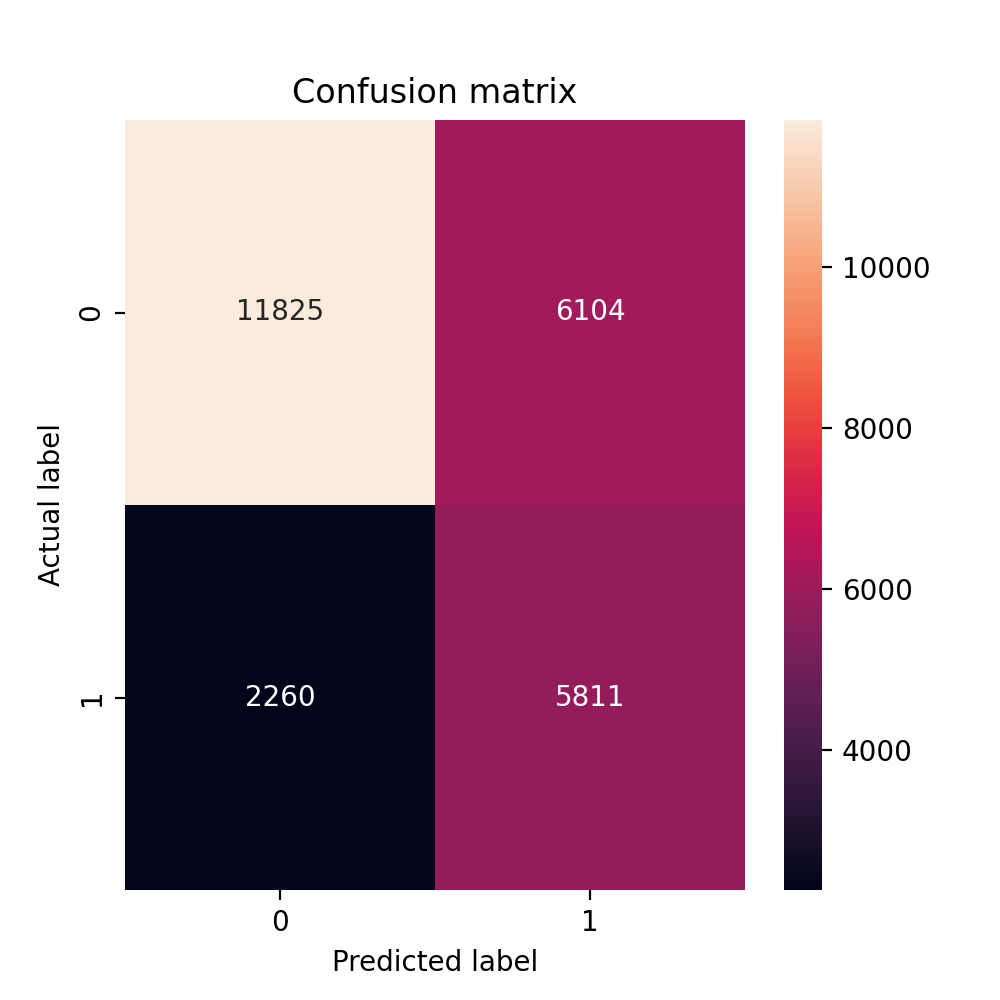

No Flow Detected (True Negatives):  11825
Flow Incorrectly Detected (False Positives):  6104
No Flow Incorrectly Detected (False Negatives):  2260
Flow Detected (True Positives):  5811
Total Flow Detected:  8071
0.6783076923076923


In [967]:
from sklearn.linear_model import LogisticRegression

# features_transformed = pipeline.transform(features)
flow = features[labels==1]
noflow = features[labels==0]
print(flow.shape)
print(noflow.shape)

# combining arrays & building labels
test_features = np.append(flow, noflow, axis=0)
test_labels = np.append(np.ones(len(flow)),
                   np.zeros(len(noflow)))

encoded_x = encoder.predict(features)

print(len(encoded_x))
print(len(labels))
train_x, val_x, train_y, val_y = train_test_split(encoded_x, labels, test_size=0.2)
# transform the test set with the pipeline fitted to the training set
# encoded_x_train = hidden_representation.predict(train_x)
# encoded_x_val = hidden_representation.predict(val_x)
from sklearn.utils import resample
df_class0 = train_x[train_y==0]
df_class1 = train_x[train_y==1]

print(df_class0.shape)
print(df_class1.shape)


df_class01 = train_y[train_y == 0]
df_class11 = train_y[train_y == 1]

maj_class1, y_train1 = resample(df_class0, df_class01,
                                 replace=True,     
                                 n_samples=30000,    
                                 random_state=123) 
maj_class2, y_train2 = resample(df_class1, df_class11,
                                 replace=True,     
                                 n_samples=30000,    
                                 random_state=123) 
print(maj_class1.shape)
print(maj_class2.shape)
print(y_train1)
print(y_train2)

cleaned_df=np.concatenate([maj_class1,maj_class2])
cleaned_df2=np.concatenate([y_train1,y_train2])


# pass the transformed test set through the autoencoder to get the reconstructed result
# reconstructions = autoencoder.predict(val_x)
# train_x = autoencoder.predict(train_x)
# reconstructions = autoencoder.predict(val_x)
clf = LogisticRegression(solver="lbfgs").fit(cleaned_df, cleaned_df2)
pred_y = clf.predict(val_x)

# print ("")
# print ("Classification Report: ")
# print (classification_report(val_y, pred_y))

# print ("")
# print ("Accuracy Score: ", accuracy_score(val_y, pred_y))

cm = confusion_matrix(val_y, pred_y)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print('No Flow Detected (True Negatives): ', cm[0][0])
print('Flow Incorrectly Detected (False Positives): ', cm[0][1])
print('No Flow Incorrectly Detected (False Negatives): ', cm[1][0])
print('Flow Detected (True Positives): ', cm[1][1])
print('Total Flow Detected: ', np.sum(cm[1]))
print((cm[0][0] + cm[1][1]) / (cm[0][0] +  cm[0][1] + cm[1][0] +cm[1][1]))

Epoch 1/50
188/188 [==============================] - 2s 4ms/step - loss: 0.5917 - accuracy: 0.6917 - val_loss: 0.8258 - val_accuracy: 0.5282
Epoch 2/50
188/188 [==============================] - 0s 2ms/step - loss: 0.5362 - accuracy: 0.7433 - val_loss: 0.8115 - val_accuracy: 0.5658
Epoch 3/50
188/188 [==============================] - 0s 2ms/step - loss: 0.5271 - accuracy: 0.7459 - val_loss: 0.8092 - val_accuracy: 0.5294
Epoch 4/50
188/188 [==============================] - 0s 2ms/step - loss: 0.5200 - accuracy: 0.7503 - val_loss: 0.8085 - val_accuracy: 0.5074
Epoch 5/50
188/188 [==============================] - 0s 2ms/step - loss: 0.5139 - accuracy: 0.7532 - val_loss: 0.7957 - val_accuracy: 0.4853
Epoch 6/50
188/188 [==============================] - 0s 2ms/step - loss: 0.5092 - accuracy: 0.7556 - val_loss: 0.8017 - val_accuracy: 0.4660
Epoch 7/50
188/188 [==============================] - 0s 2ms/step - loss: 0.5064 - accuracy: 0.7572 - val_loss: 0.7867 - val_accuracy: 0.4613
Epoch 

<IPython.core.display.Javascript object>


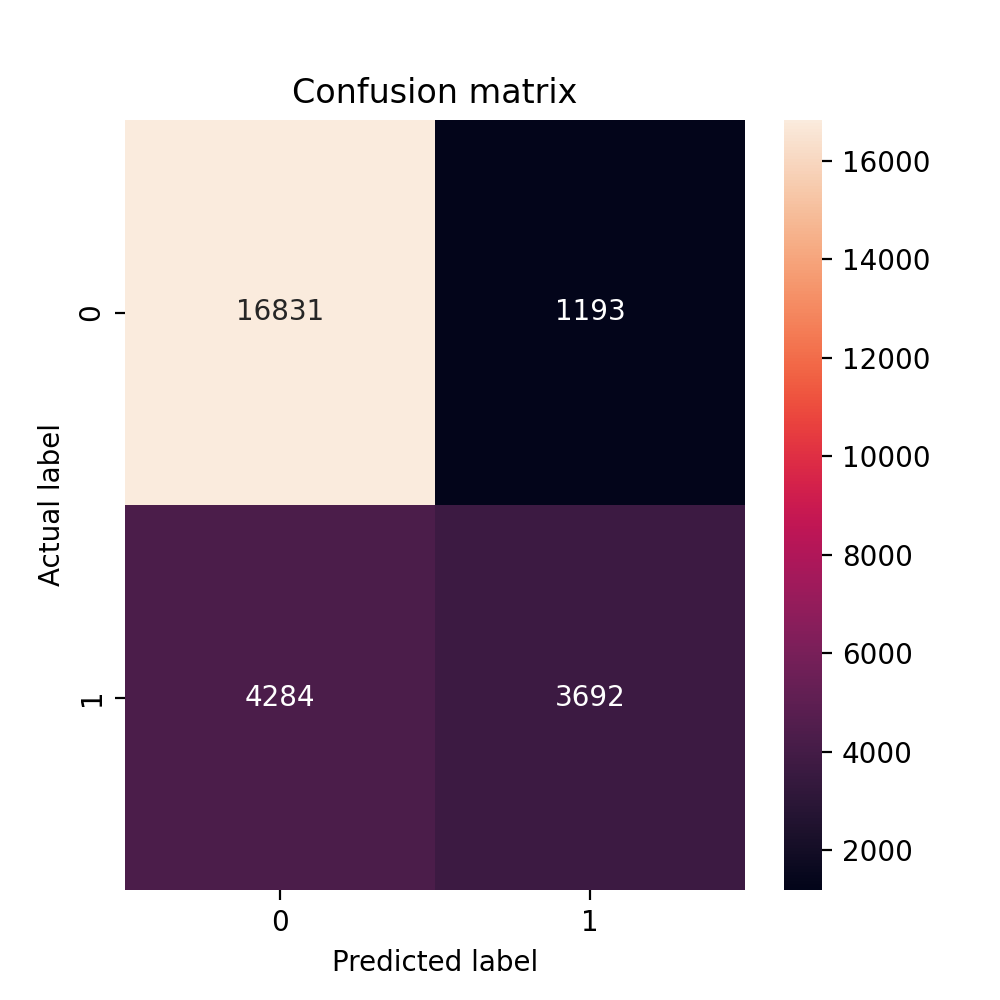

No Flow Detected (True Negatives):  16831
Flow Incorrectly Detected (False Positives):  1193
No Flow Incorrectly Detected (False Negatives):  4284
Flow Detected (True Positives):  3692
Total Flow Detected:  7976
0.7893461538461538


In [966]:
model = keras.Sequential([
          keras.layers.Dense(
              128, activation='tanh',
              input_shape=(3,)),
        keras.layers.Dense(
              64, activation='tanh'),
        keras.layers.Dense(
              32, activation='tanh'),
         keras.layers.Dense(
              16, activation='tanh'),
              keras.layers.Dense(
              8, activation='tanh'),
#           keras.layers.Dropout(0.5),
          keras.layers.Dense(1, activation='sigmoid'),
      ])

model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-4),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=['accuracy'])

model.fit(cleaned_df, cleaned_df2,
    batch_size=256,
    callbacks=cb,
    epochs=50,
         validation_split = 0.20)

# results = model.evaluate(train_x, train_y, batch_size = 1024, verbose=0)
pred_y = model.predict(val_x)
print(pred_y)

cm = confusion_matrix(val_y, pred_y > 0.5)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print('No Flow Detected (True Negatives): ', cm[0][0])
print('Flow Incorrectly Detected (False Positives): ', cm[0][1])
print('No Flow Incorrectly Detected (False Negatives): ', cm[1][0])
print('Flow Detected (True Positives): ', cm[1][1])
print('Total Flow Detected: ', np.sum(cm[1]))
print((cm[0][0] + cm[1][1]) / (cm[0][0] +  cm[0][1] + cm[1][0] +cm[1][1]))

In [954]:
val_y

array([0., 0., 1., ..., 0., 0., 0.])

## Compare

In [1006]:
from scipy.special import softmax
from statistics import median

def compare():
    df = df_data.copy().reset_index(drop=True)
    total = 0
    true = 0
    max_flow_rl = 0.029
    for p in powder.unique():
        df_ = df[df['Powder'] == p]
        df_ = resample_(df_, target="Powder", n=1000)
        flowrate = df_.pop('Flow')
        df_.pop('Powder')
        fl = df_.pop('Flow Class')
#         df_ = pd.DataFrame(scaler.transform(df_), columns=df_.columns)
        scaled = pipeline.transform(df_)
        reconstructions_no = autoencoder.predict(scaled)
        mse = np.mean(np.power(scaled - reconstructions_no, 2), axis=1)


# #         x = encoder.predict(scaled)
# #         preds = model.predict(x)
#         guesses = []
#         for pred in preds:
# #             sf = softmax(pred)
# #             c = np.argmax(sf)
#             guesses.append(pred)
#             mode,count = scipy.stats.mode(guesses)
# #             median_ = median(guesses)
        m = np.mean(mse)
        ma = np.max(mse)
        print(f"Powder: {p} | Actual Flow Class: {fl.iloc[0]} | Pred: {int(ma < max_flow_rl)} | Max RL: {ma:.3f}")
        true += int(fl.iloc[0] == int(ma < max_flow_rl))
        total += 1
    print(true/total)
compare()

Powder: S1VRC0706-3_Excel.txt | Actual Flow Class: 1 | Pred: 1 | Max RL: 0.015
Powder: WIP-C1.txt | Actual Flow Class: 1 | Pred: 1 | Max RL: 0.003
Powder: WIP-W1.txt | Actual Flow Class: 1 | Pred: 1 | Max RL: 0.018
Powder: MW_Ti-Nb-Zr_0-63.txt | Actual Flow Class: 1 | Pred: 1 | Max RL: 0.013
Powder: WIP-W2.txt | Actual Flow Class: 1 | Pred: 1 | Max RL: 0.012
Powder: MW_Ti-Nb-Zr_64-150.txt | Actual Flow Class: 1 | Pred: 1 | Max RL: 0.003
Powder: MW_I_718_0-10.txt | Actual Flow Class: 0 | Pred: 1 | Max RL: 0.014
Powder: S1VRC0706-5_Excel.txt | Actual Flow Class: 0 | Pred: 1 | Max RL: 0.009
Powder: V5_Al-P1015_99.8%-Al.txt | Actual Flow Class: 1 | Pred: 1 | Max RL: 0.007
Powder: MW_Ti-Nb_64-150.txt | Actual Flow Class: 1 | Pred: 1 | Max RL: 0.005
Powder: S1VRC0706-2_Excel.txt | Actual Flow Class: 1 | Pred: 1 | Max RL: 0.000
Powder: MW_SS-17-4_64-150.txt | Actual Flow Class: 1 | Pred: 1 | Max RL: 0.000
Powder: Lincoln_SHS_7574HV.txt | Actual Flow Class: 1 | Pred: 1 | Max RL: 0.001
Powder: 